In [37]:
import numpy as np
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from IPython.display import display
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline  
plt.rcParams['figure.dpi'] = 400

plt.style.use('science')

def plot_feature_importance_comparison(models, X_test, y_test, colors=None,coefs = None):
    # Dictionary to store feature importance results
    fi_results = {}

    for model_name, model in models.items():
        fi = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
        fi_results[model_name] = fi.importances_mean

    # Extract feature names
    feature_names = list(X_test.columns)

    # Create a DataFrame for feature importance results
    importance_df = pd.DataFrame(fi_results, index=feature_names)
    with plt.style.context('science'):
        # Plot grouped bar chart
        fig, ax = plt.subplots(figsize=(6, 3))

        bar_width = 0.1
        bar_positions = np.arange(len(feature_names))

        for i, (model, importance) in enumerate(importance_df.items()):
            color = colors[i] if colors is not None else None
            ax.bar(bar_positions + (i * bar_width), importance, width=bar_width, label=model, color=color)

        # Add labels, title, and legend
        ax.set_xticks(bar_positions + 2.5 * bar_width)
        ax.set_xticklabels(feature_names, rotation=0, ha='right')
        ax.set_ylabel('Importance')
        # Shrink current axis's height by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                        box.width, box.height * 0.9])

        # Put a legend below current axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                fancybox=True, shadow=True, ncol=3,fontsize = 'x-small')
        plt.show()
def plot_feature_mean_squared_error(models, X, y, colors=None,cv = 5,random_state = 123):
    # Dictionary to store feature importance results
    
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # Define a function to calculate RMSE
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    # Create a scorer using the RMSE function
    rmse_scorer = make_scorer(rmse, greater_is_better=False)

    mean_rmse = {}
    model_names = []
    for model_name,model in models.items():
        cross_val_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
        mean_rmse[model_name] = -np.mean(cross_val_scores)
        model_names.append(model_name)
    with plt.style.context('science'):
        # Plot grouped bar chart
        fig, ax = plt.subplots(figsize=(6, 2))
        bar_width = 0.1
        plt.barh(model_names, mean_rmse.values(),color = colors)
        plt.xlabel('Root Mean Squared Error')
        plt.show()

# Simulation Studies

## Linear Relation

1.Simulation studies 
for checking PDP and PFI methods pros and cons
nopise mean is zero and variance is 0.1

$ {y^i = x_1^i + x_2^i + x_3^i+ x_4^i + \epsilon}$

Covariance matrix :
${\begin{bmatrix}
1 & 0 & 0& 0\\
0 & 1 & 0& 0\\
0 & 0 & 1& 0\\
0 & 0 & 0& 1\\
\end{bmatrix}}$

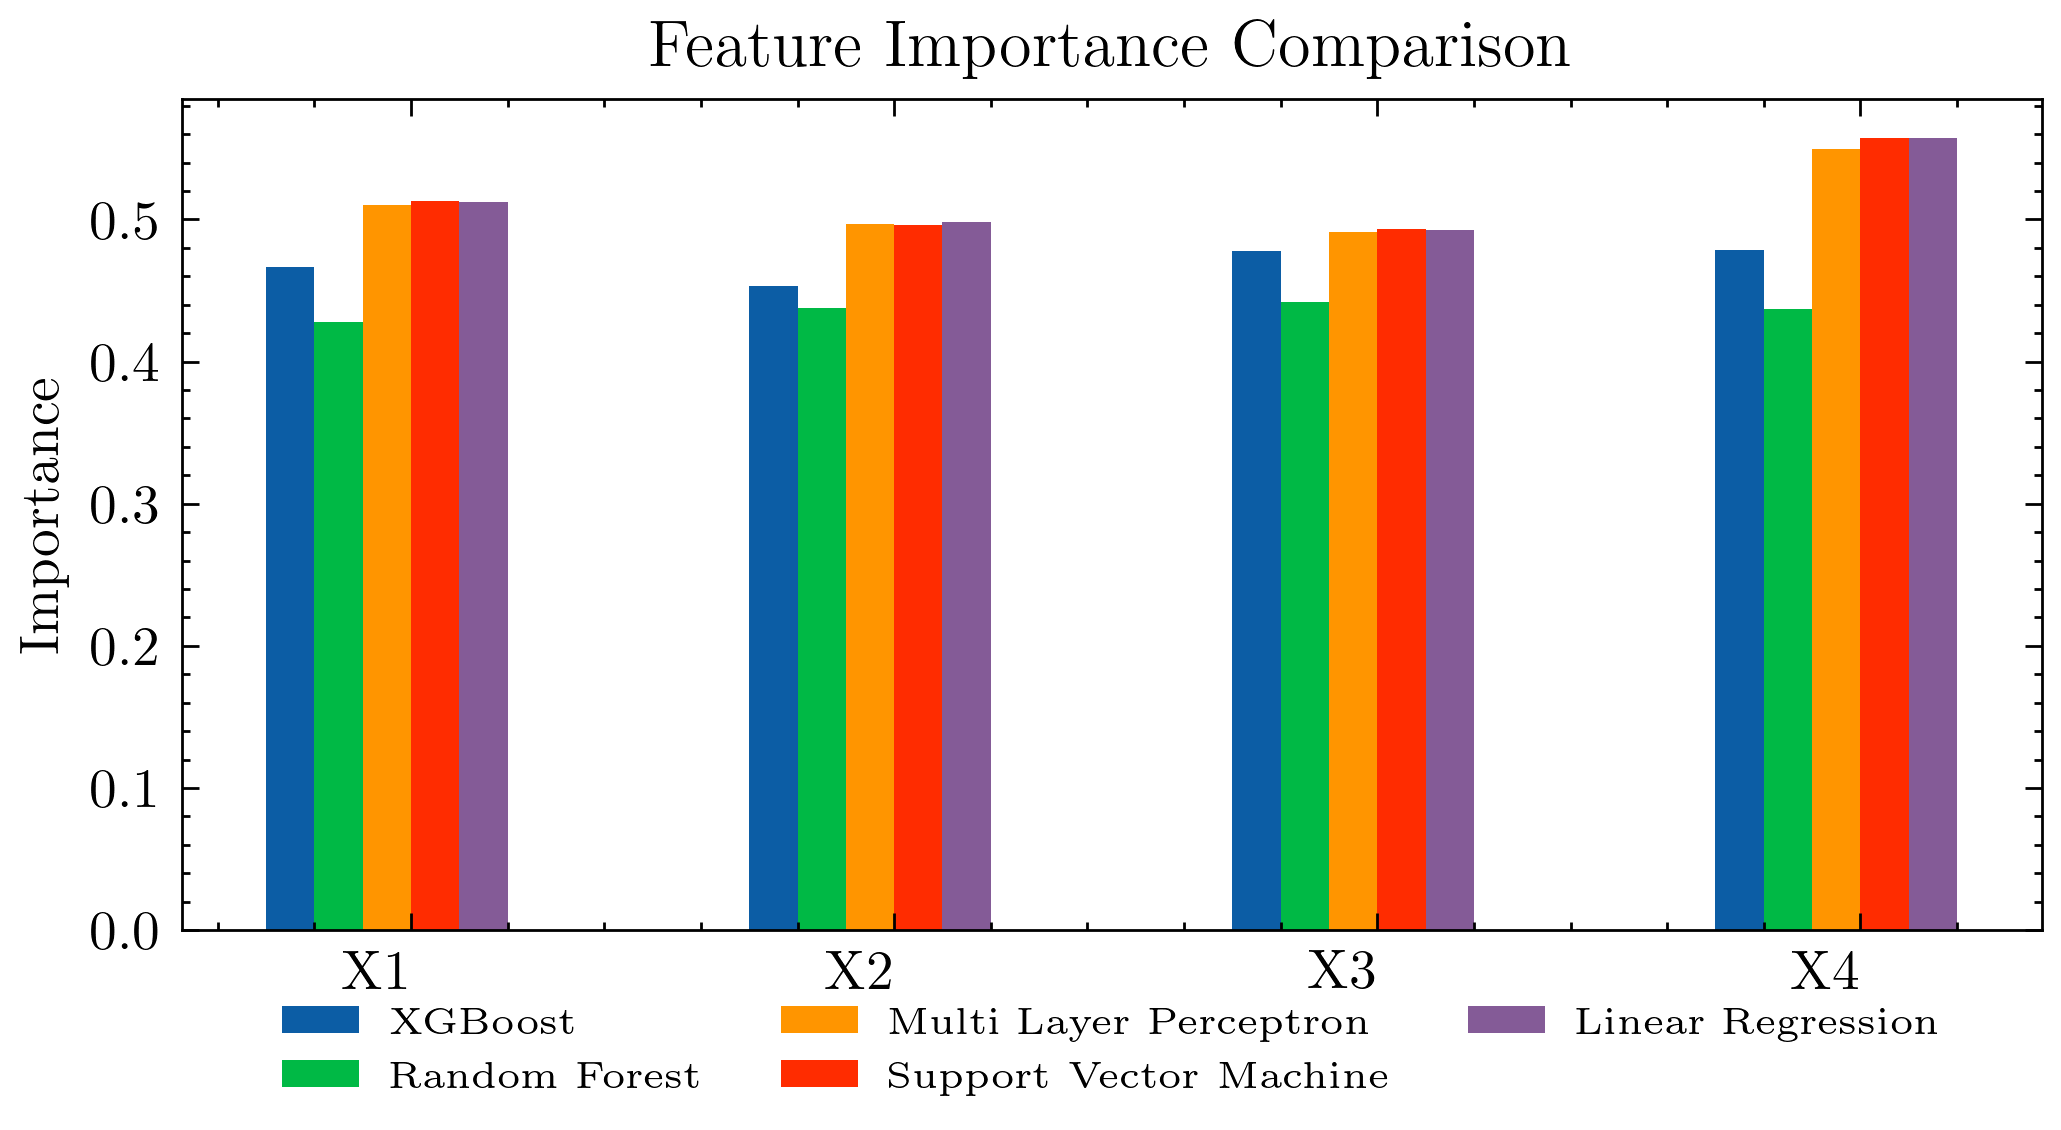

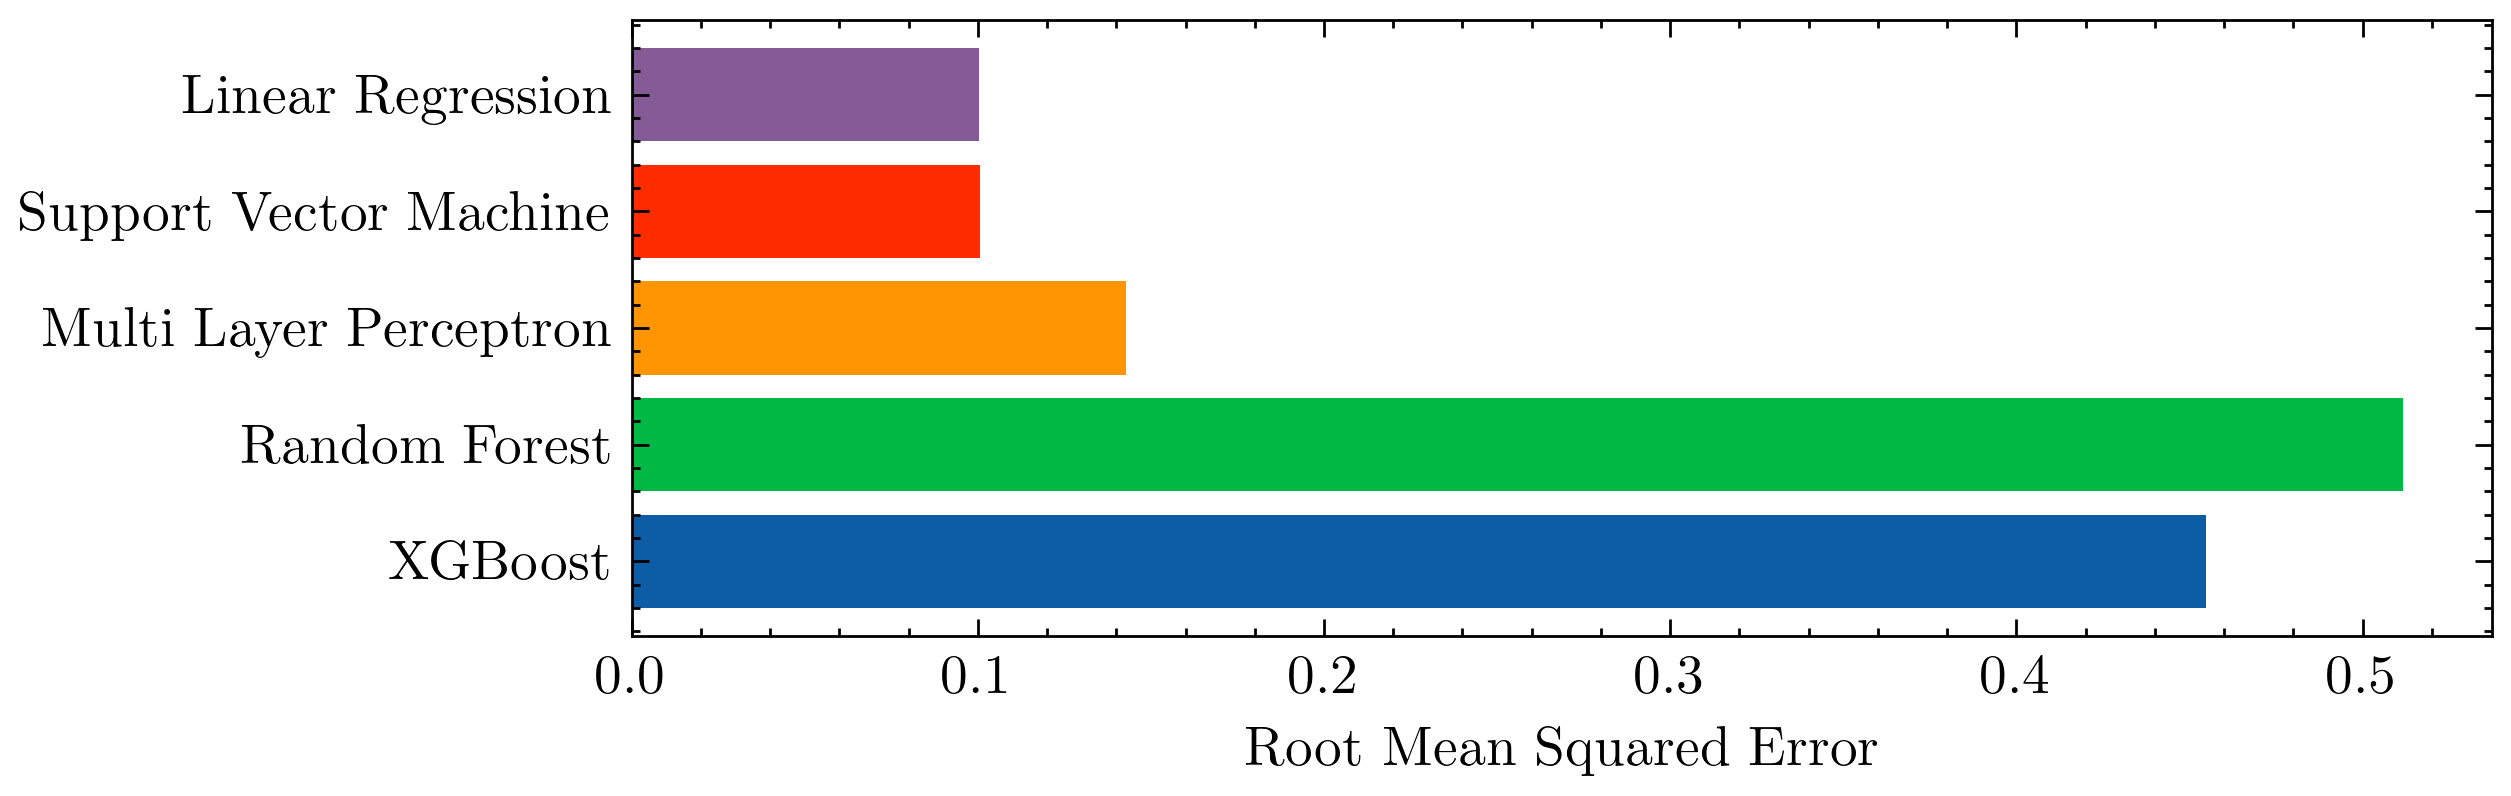

In [38]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(123)

num_samples = 1500

# Generating each feature separately
X1 = np.random.randn(num_samples)  # Feature 1
X2 = np.random.randn(num_samples)  # Feature 2
X3 = np.random.randn(num_samples)  # Feature 3
X4 = np.random.randn(num_samples)  # Feature 4

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.1, num_samples)  # Adding noise
y = X1 + X2 + X3 + X4 + noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
num_colors = 10
custom_colors = color_cycle[:num_colors]

plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

In [39]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-2, 2)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

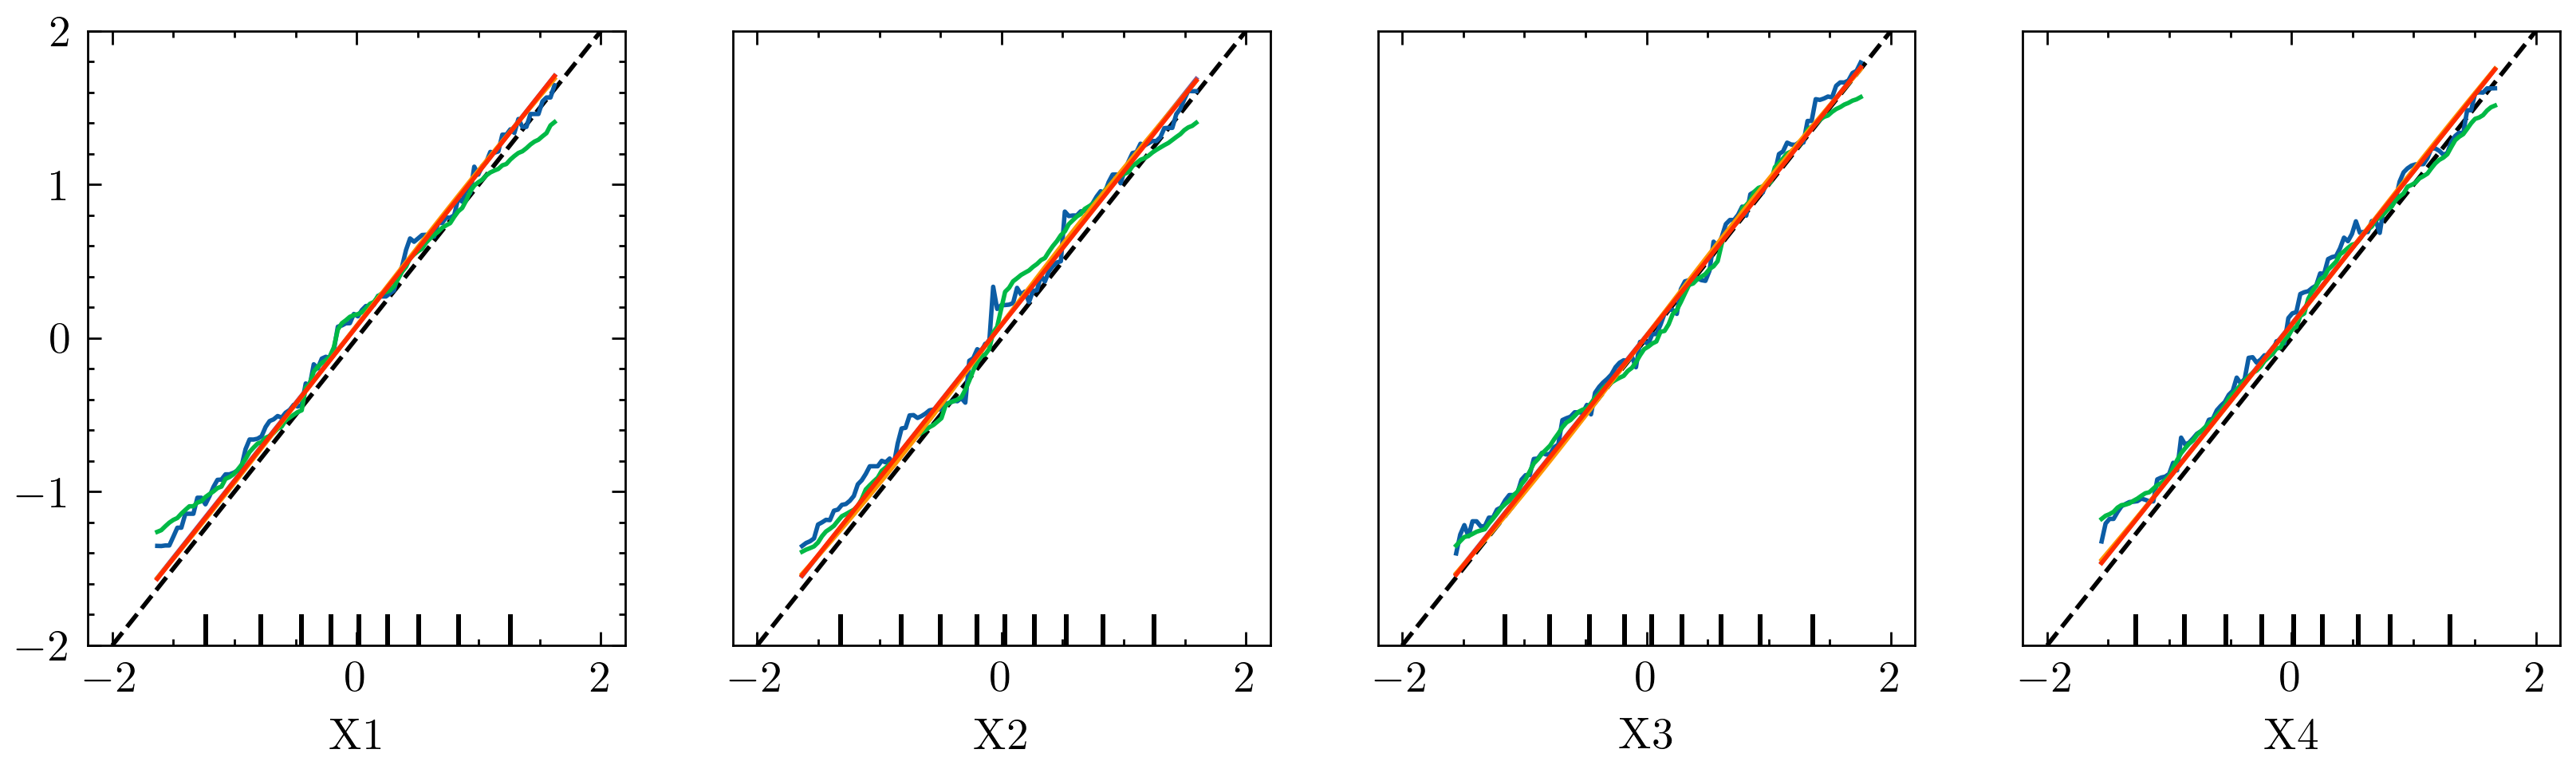

In [41]:
display(my_plot)

2.Large variance of error (noise std = 1)

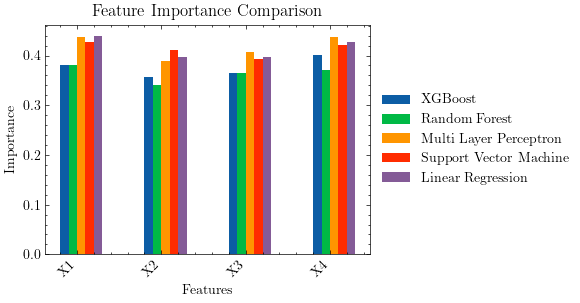

C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


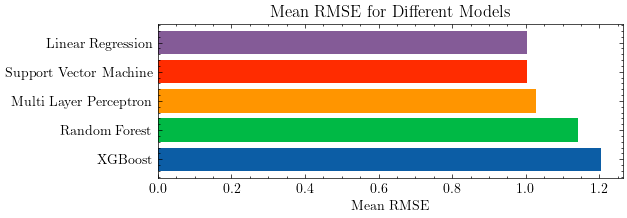

In [24]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(123)

num_samples = 1500

# Generating each feature separately
X1 = np.random.randn(num_samples)  # Feature 1
X2 = np.random.randn(num_samples)  # Feature 2
X3 = np.random.randn(num_samples)  # Feature 3
X4 = np.random.randn(num_samples)  # Feature 4

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 1, num_samples)  # Adding noise
y = X1 + X2 + X3 + X4 + noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}


plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)


In [25]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-2, 2)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

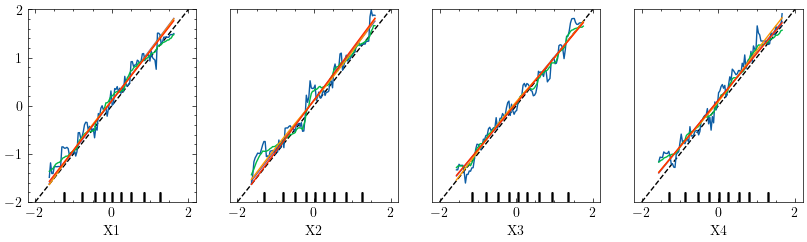

In [26]:
display(my_plot)

result : variance of noise does not have a signinficant effect on the plots but tree based ensembles plots become more volatile.


3.Simulation Changing weight of variable 
for checking PDP and PFI methods pros and cons
nopise mean is zero and variance is 0.1

$ {y^i = 5 * x_1^i + x_2^i + x_3^i+ x_4^i + \epsilon}$

Covariance matrix :
${\begin{bmatrix}
1 & 0 & 0& 0\\
0 & 1 & 0& 0\\
0 & 0 & 1& 0\\
0 & 0 & 0& 1\\
\end{bmatrix}}$

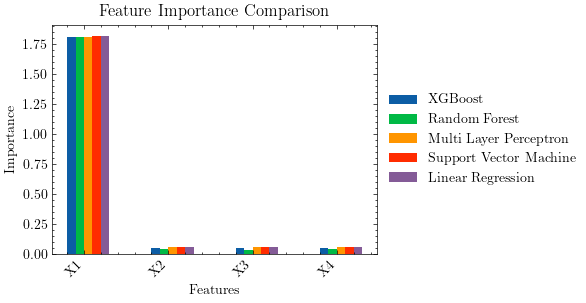

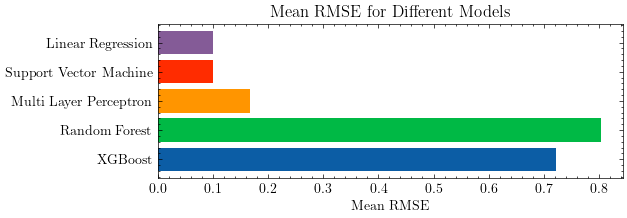

In [27]:

# Generating each feature separately
X1 = np.random.randn(num_samples)  # Feature 1
X2 = np.random.randn(num_samples)  # Feature 2
X3 = np.random.randn(num_samples)  # Feature 3
X4 = np.random.randn(num_samples)  # Feature 4

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.1, num_samples)  # Adding noise
y = 5*X1 + X2 + X3 + X4 + noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}


plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)


In [28]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, 5*x_vals, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-10, 10)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

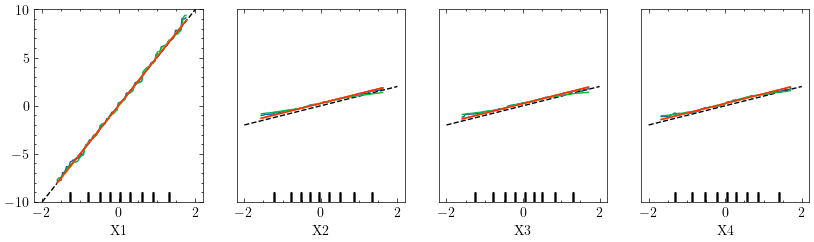

In [29]:
display(my_plot)

3.result
PDP effect of x1 increased as expected. there is a little variance in XGBoost and random froest mpdels plots near the margin are but they still could capture the trends in the data perfectly.


4.Simulation Chaning weight of variable
for checking PDP and PFI methods pros and cons
nopise mean is zero and variance is 0.1

$ {y^i = 0 * x_1^i + x_2^i + x_3^i+ x_4^i + \epsilon}$

Covariance matrix :
${\begin{bmatrix}
1 & 0 & 0& 0\\
0 & 1 & 0& 0\\
0 & 0 & 1& 0\\
0 & 0 & 0& 1\\
\end{bmatrix}}$

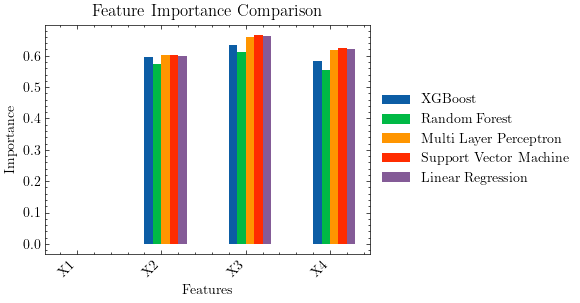

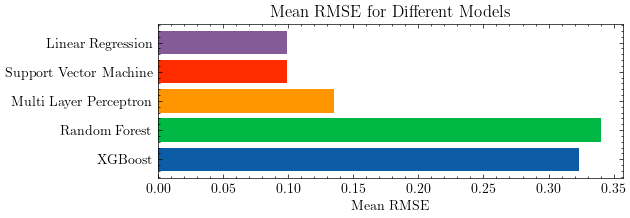

In [30]:

# Generating each feature separately
X1 = np.random.randn(num_samples)  # Feature 1
X2 = np.random.randn(num_samples)  # Feature 2
X3 = np.random.randn(num_samples)  # Feature 3
X4 = np.random.randn(num_samples)  # Feature 4

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.1, num_samples)  # Adding noise
y = 0*X1 + X2 + X3 + X4 + noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}


plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)


In [31]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, 0*x_vals, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-2, 2)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

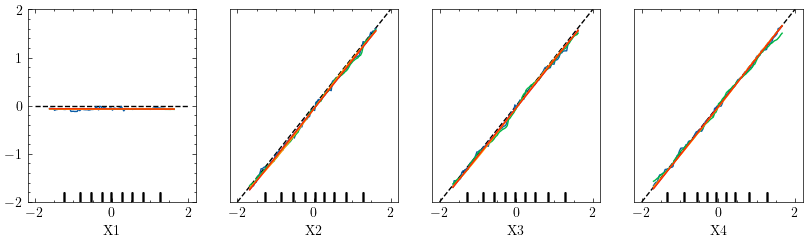

In [32]:
display(my_plot)

4.result : same result as 5 times X_1 but variance near margin areas do not show any sing of divergence


5.Simulation correlation case  

for checking PDP and PFI methods pros and cons
nopise mean is zero and variance is 0.1

$ {y^i =  x_1^i + x_2^i + x_3^i+ x_4^i + \epsilon}$

Covariance matrix :
${\begin{bmatrix}
1 & 0.95 & 0& 0\\
0.95 & 1 & 0& 0\\
0 & 0 & 1& 0.5\\
0 & 0 & 0.5& 1\\
\end{bmatrix}}$

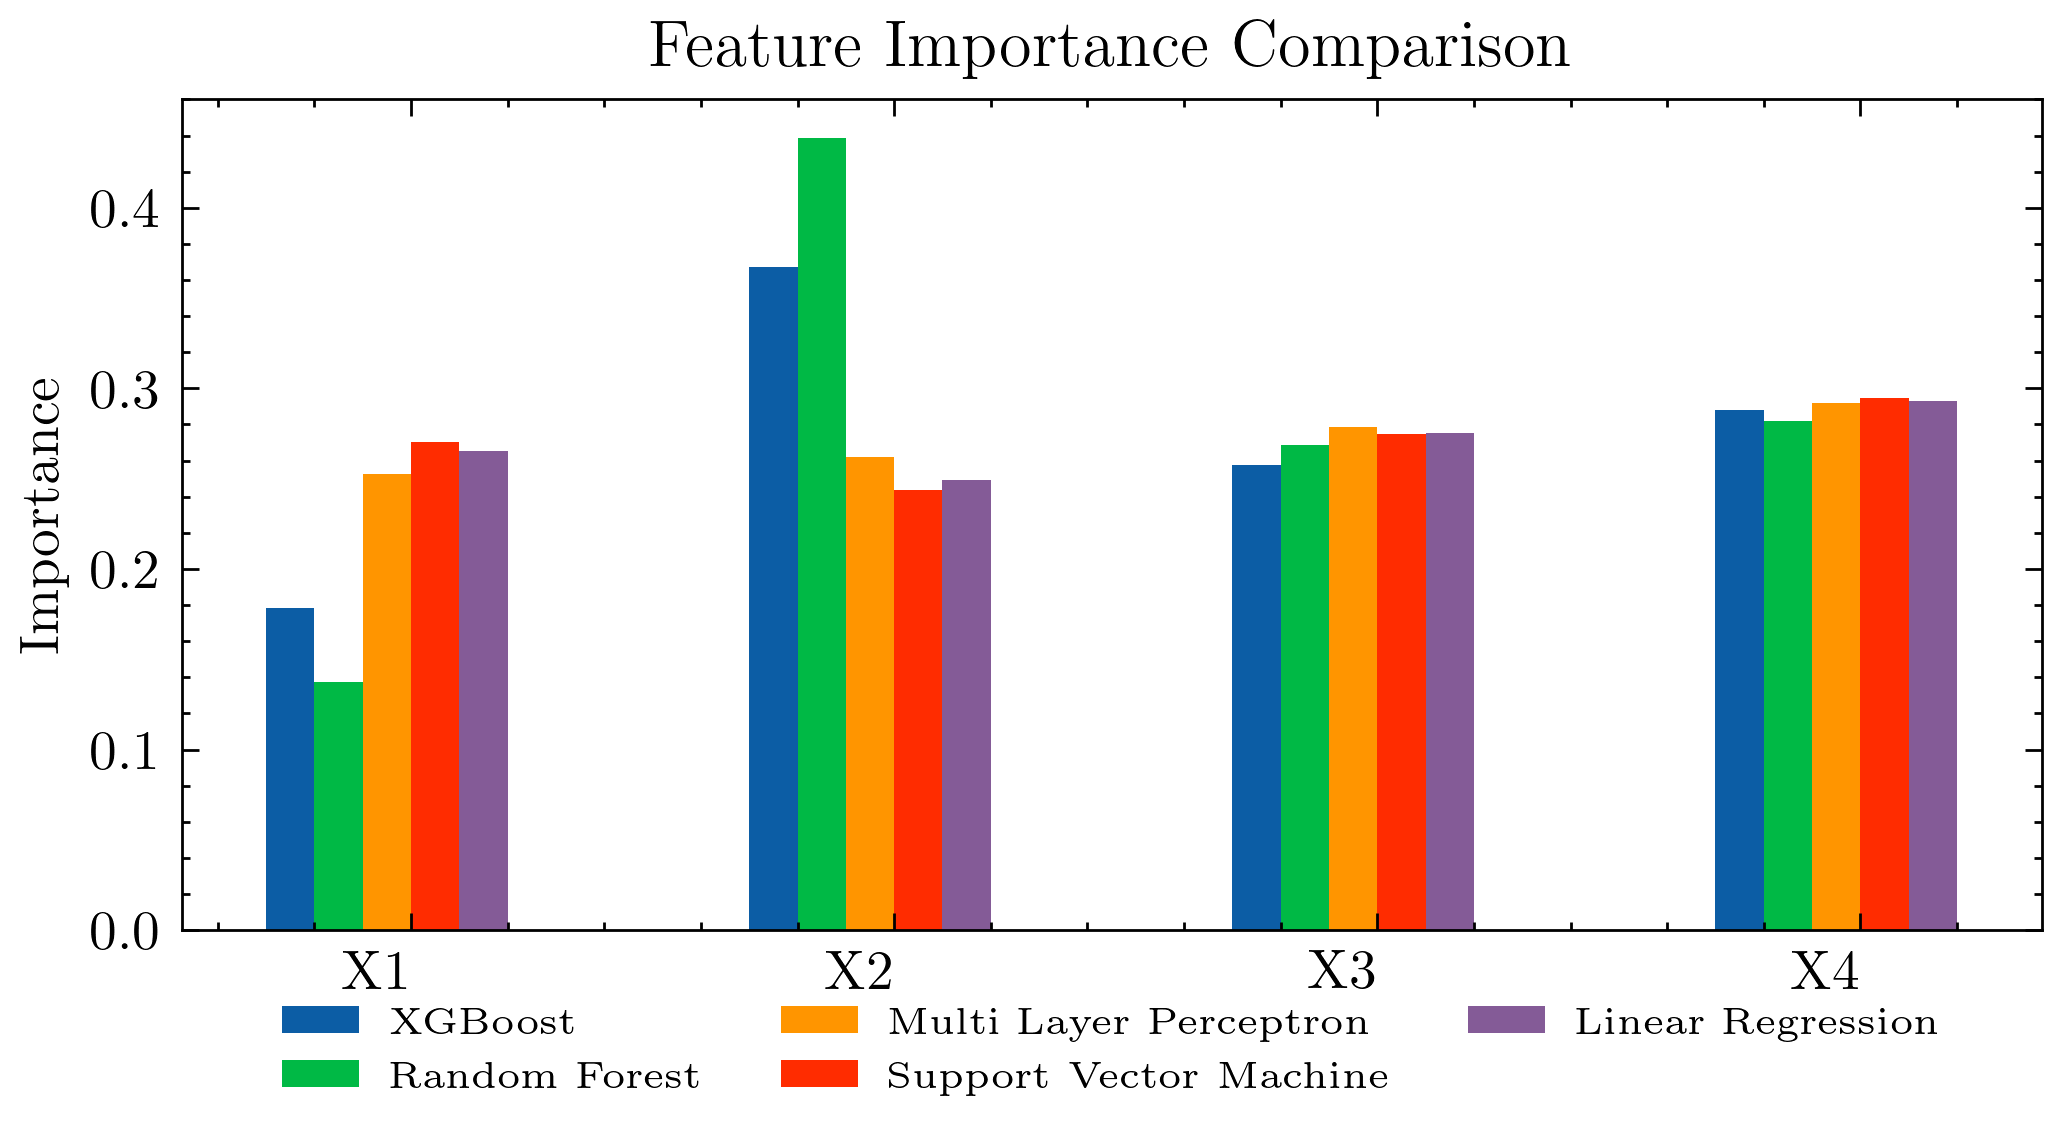

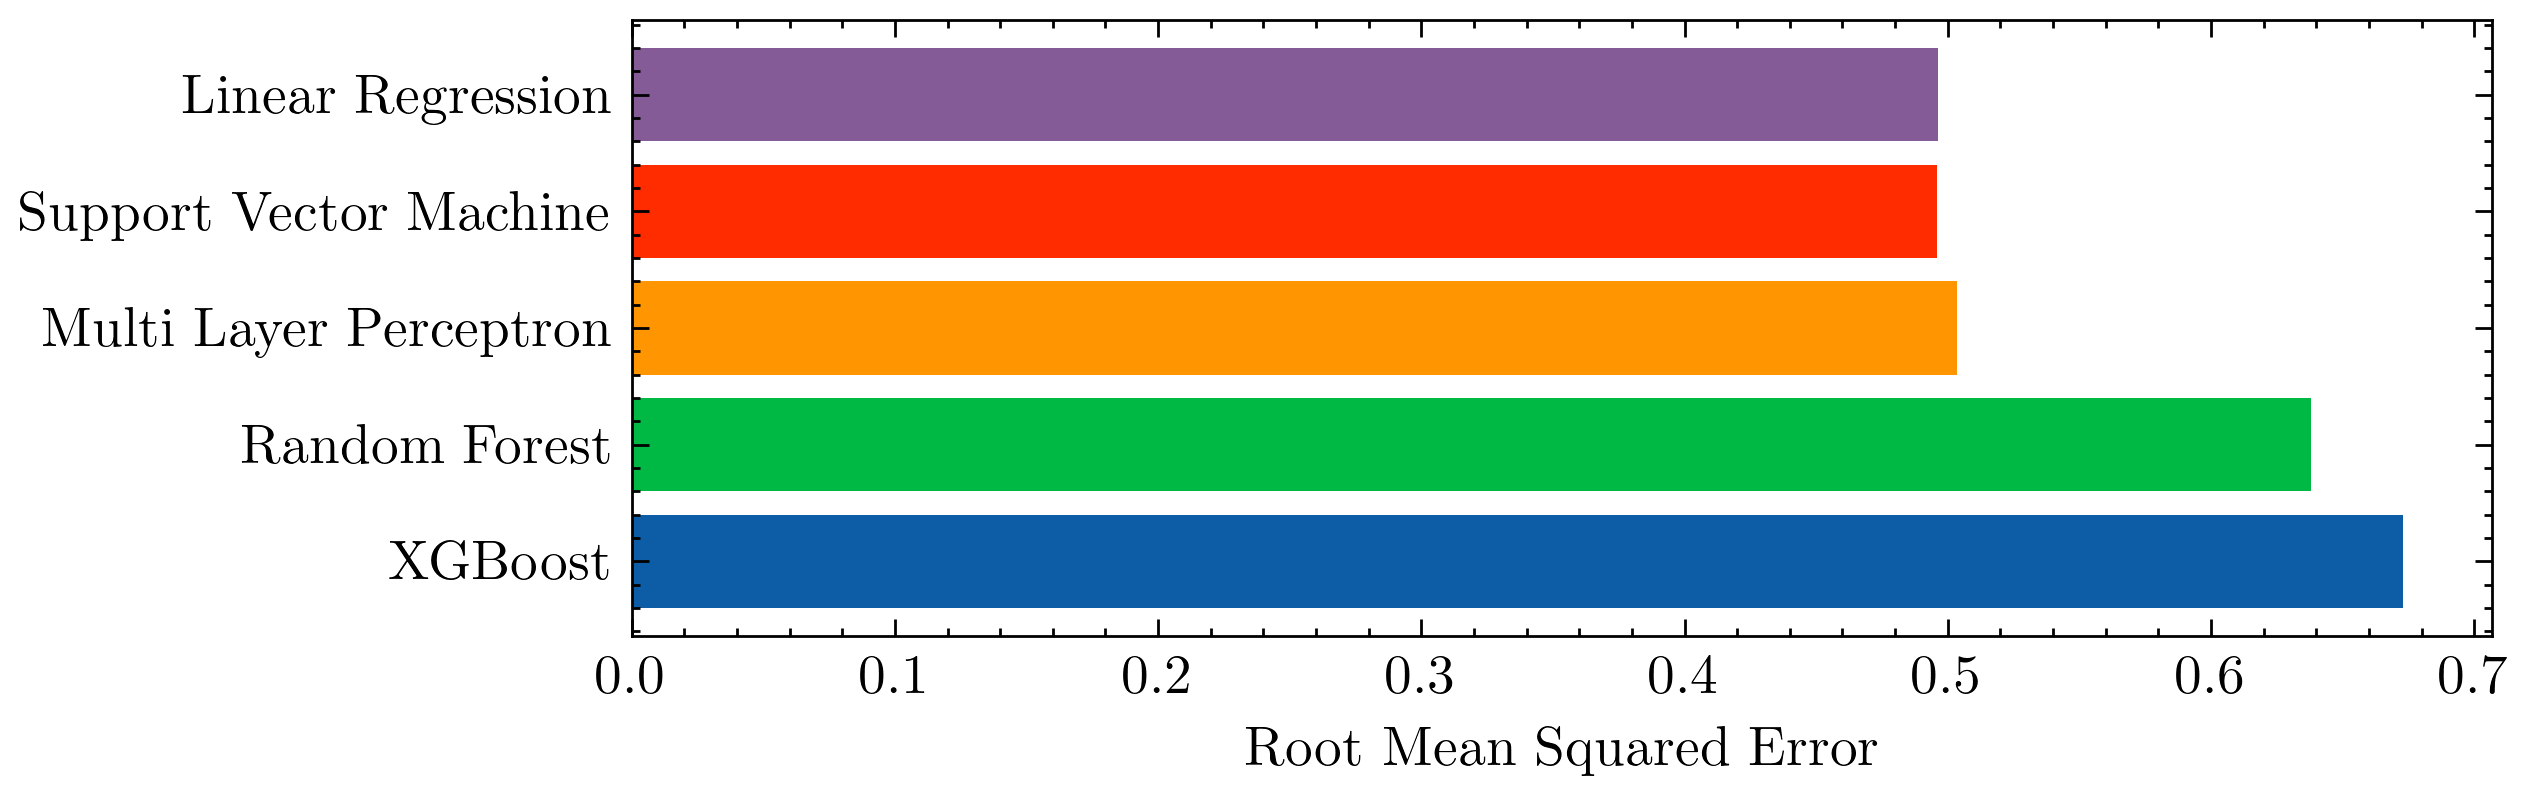

In [49]:
mean = [0, 0, 0, 0]
cov = [[1, 0.95, 0, 0], [0.95, 1, 0, 0], [0, 0, 1, 0.5], [0, 0, 0.5, 1]]
XS = np.random.multivariate_normal(mean, cov, num_samples)
X1 = XS[:, 0]
X2 = XS[:, 1]
X3 = XS[:, 2]
X4 = XS[:, 3]

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.5, num_samples)  # Adding noise
y = X1 + X2 + X3 + X4 + noise

data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)
# Splitting the dataset into training and testing sets

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
mlp_reg = MLPRegressor(hidden_layer_sizes=100, max_iter=1000)
mlp_reg.fit(X_train, y_train)
# Evaluate models
data = pd.DataFrame({"X1": X1, "X2": X2, "X3": X3, "X4": X4, "y": y})
# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}


plot_feature_importance_comparison(
    models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

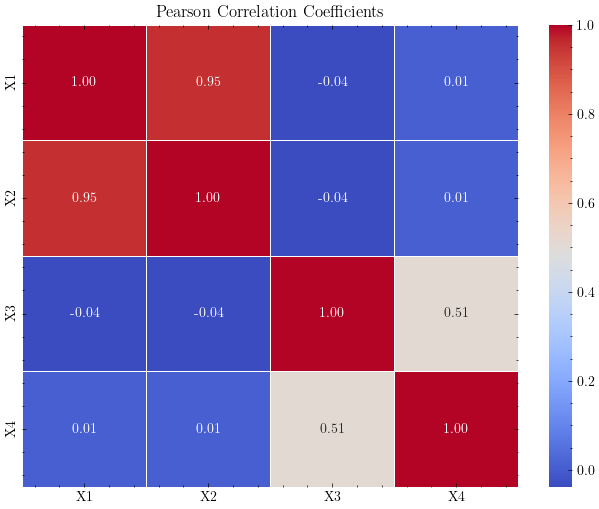

In [34]:
# Show Pearson correlation coefficients
correlation_matrix = data.drop("y",axis=1).corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Coefficients')
plt.show()

In [50]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-3, 3)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

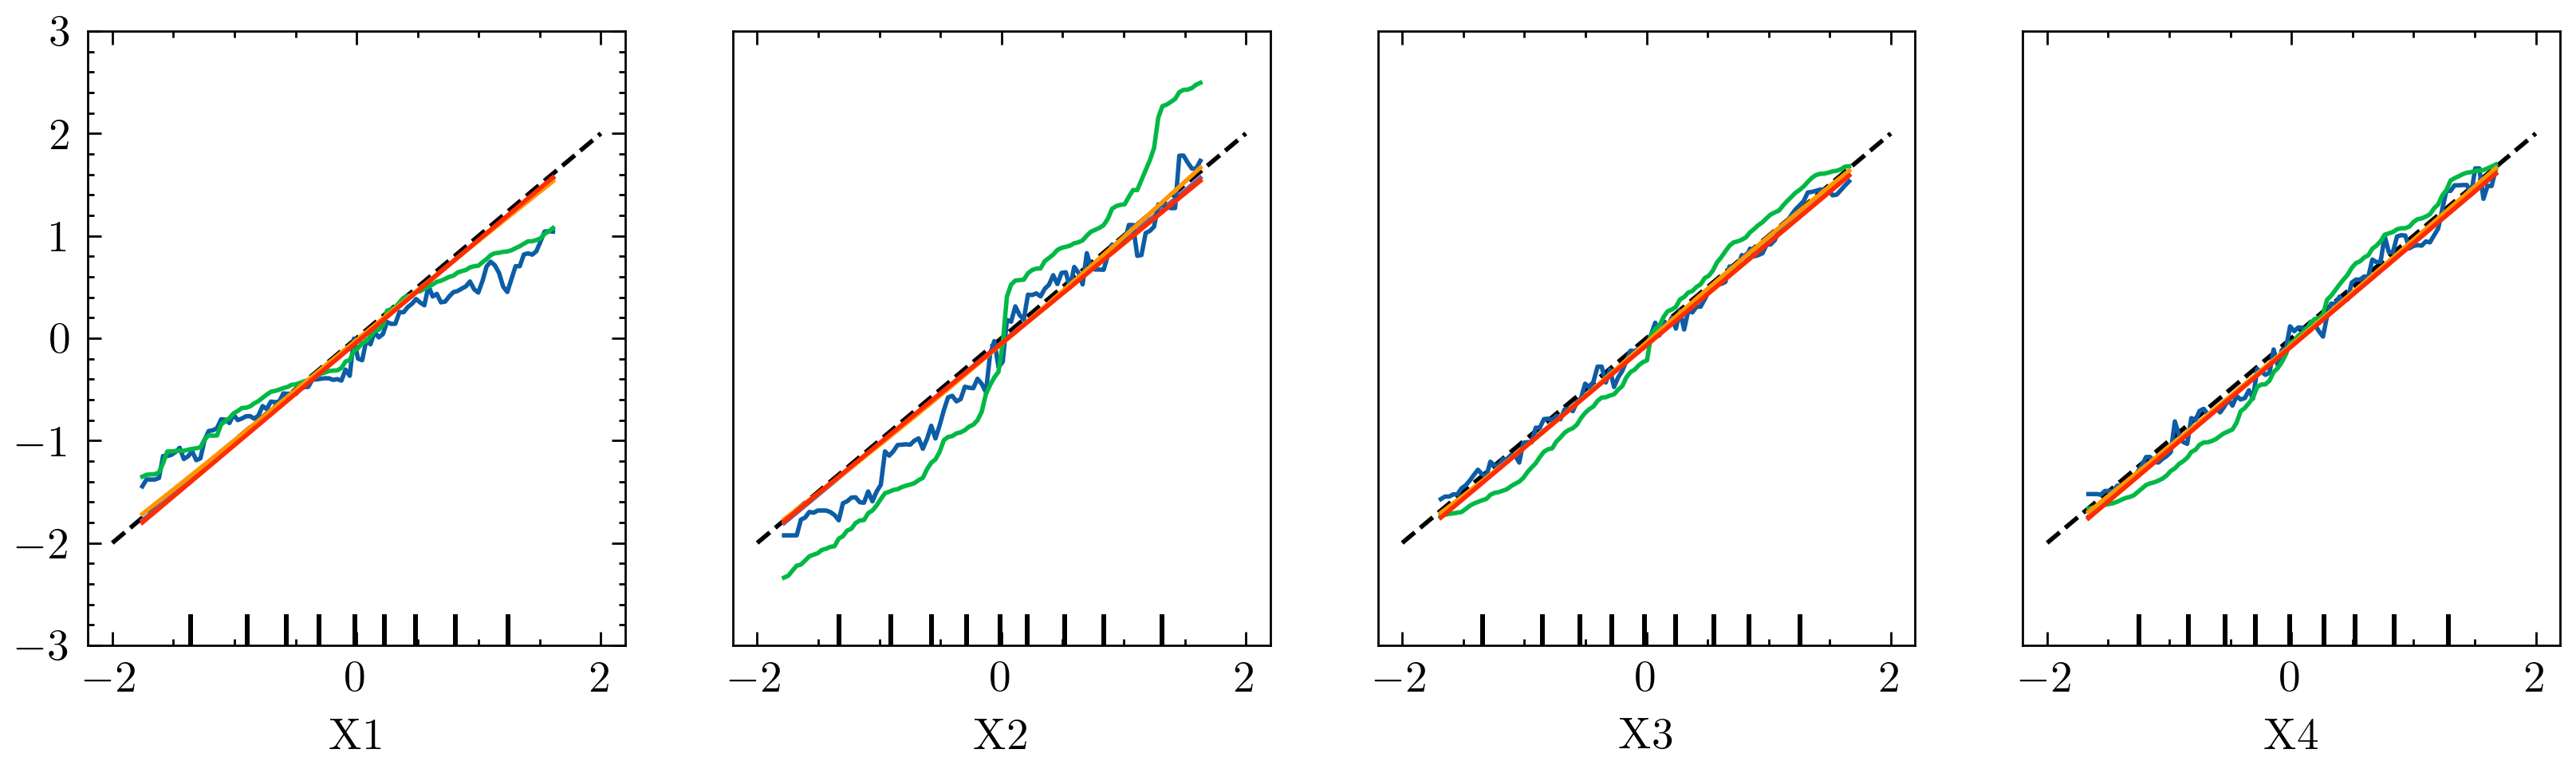

In [51]:
display(my_plot)

5.result
in presence of correlate feature in linear regression and dnn show more smooth shape for the correlated feature 
In simulated experiments where linear correlations exist among features, the performance divergence between tree-based models like Random Forests (RF) and XGBoost (XGB) versus Multilayer Perceptrons (MLPs) can be delineated by their aptitude in capturing linear relationships.

In scenarios where the relationship among features follows a linear pattern (e.g., X1 + X2 + X3 + noise), tree-based models such as RF and XGB outperform MLPs due to their inherent capacity to discern and utilize linear correlations. These models leverage decision trees to partition the feature space, effectively capturing linear relationships among correlated features. Consequently, when confronted with correlated features like X1, X2, and X3, tree-based models construct splits that correspond to these correlations, enabling the approximation of linear relationships within the data.

Conversely, MLPs, characterized by their neural network architecture, are more inclined to learn complex and non-linear patterns. In scenarios with linear correlations, MLPs might represent these relationships in higher-level abstractions, resulting in smoother Partial Dependence Plots (PDPs) for correlated features. This smoothness might indicate the model's abstraction of linear relationships rather than explicit capture, leading to a perception of reduced fidelity in depicting linear correlations compared to tree-based models.

However, it's important to consider that while tree-based models excel in capturing linear relations, they may lack the capability to represent intricate non-linear patterns. MLPs, with their ability to capture complex relationships, might offer better representation of non-linear structures but potentially display smoother PDPs for linear correlations.

6.Feature interaction

interaction nopise mean is zero and variance is 0.5

$ {y^i = x_1^i + x_2^i + x_3^i+ x_4^i + \epsilon}$

Covariance matrix :
${\begin{bmatrix}
1 & 1 & 0& 0\\
1 & 1 & 0& 0\\
0 & 0 & 1& 0.2\\
0 & 0 & 0.2& 1\\
\end{bmatrix}}$

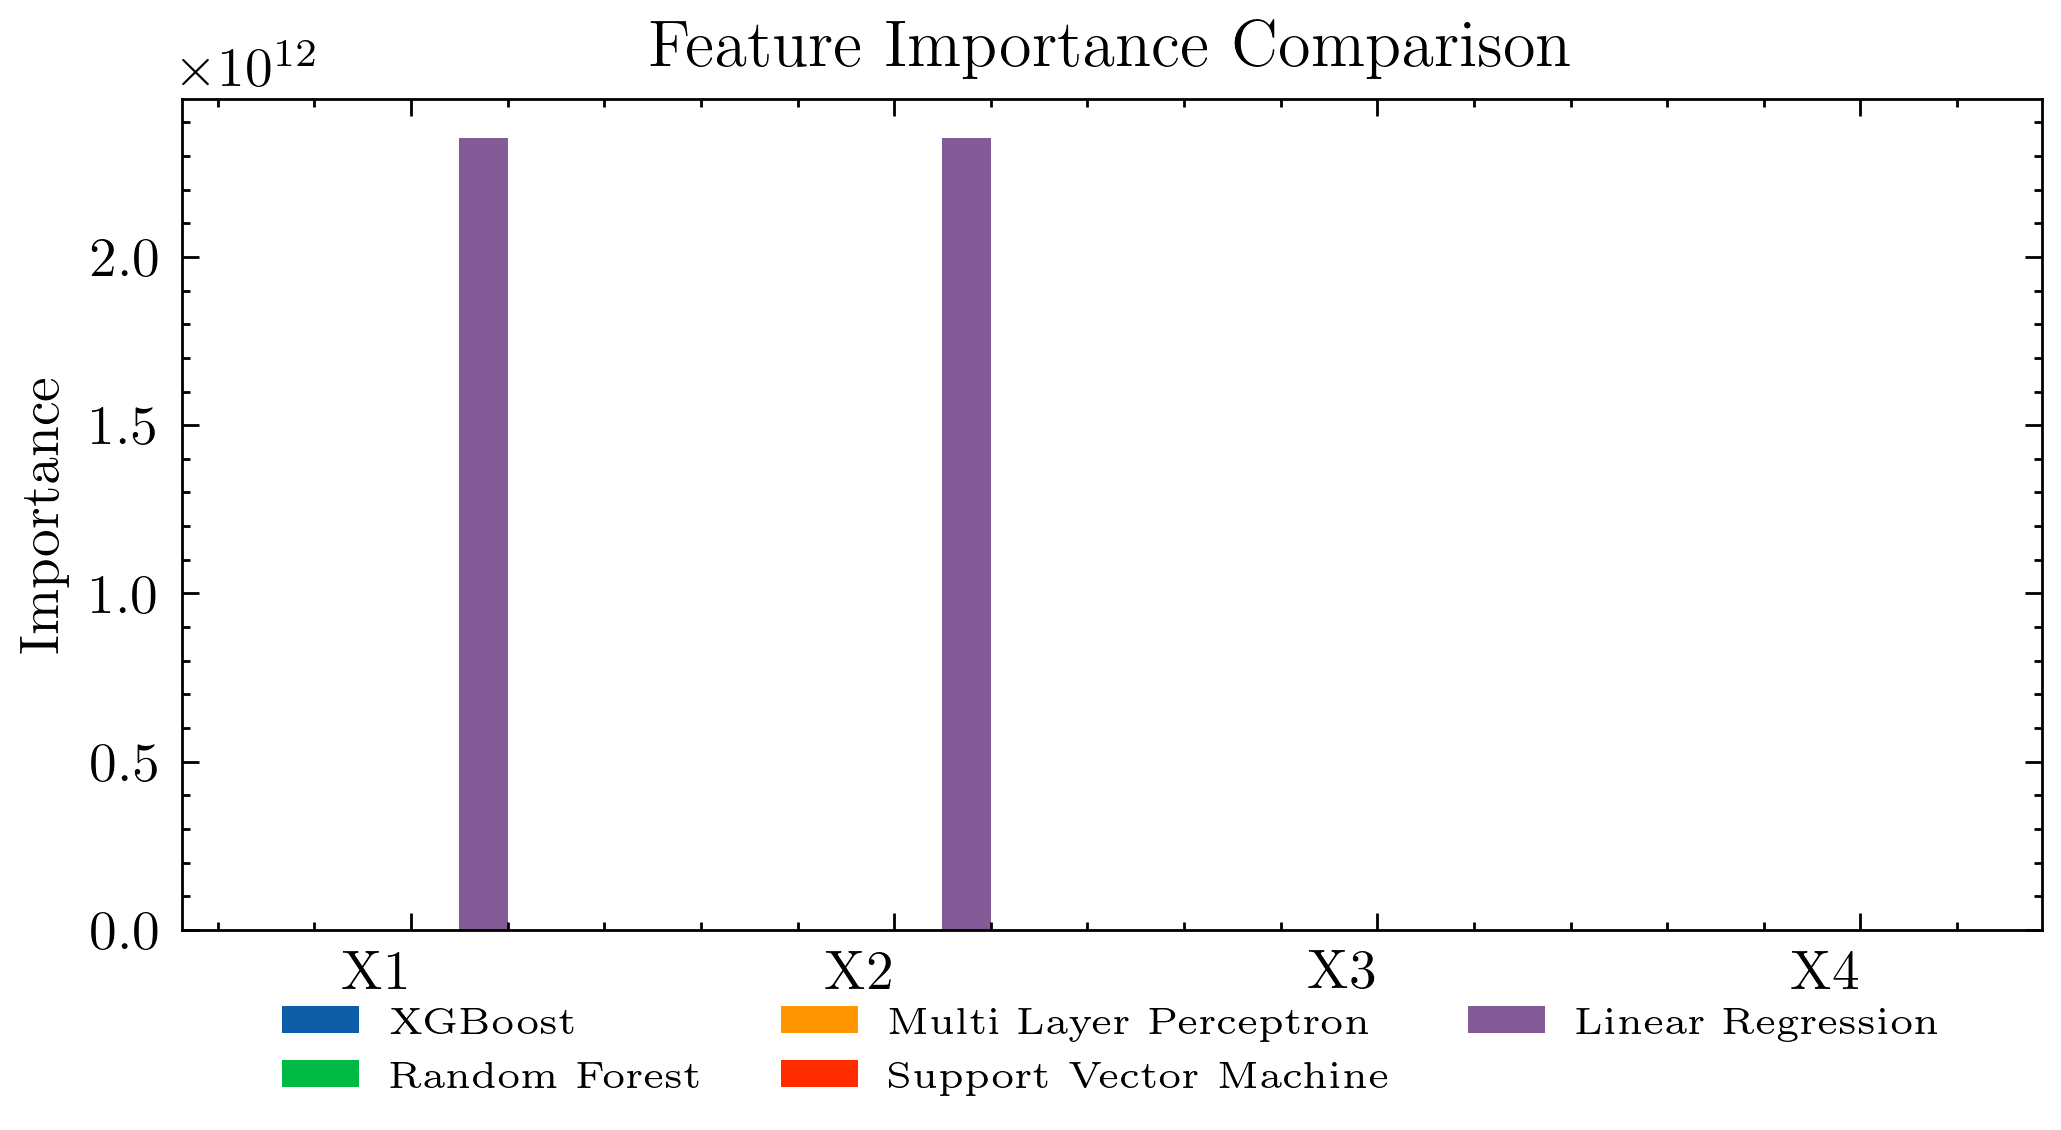

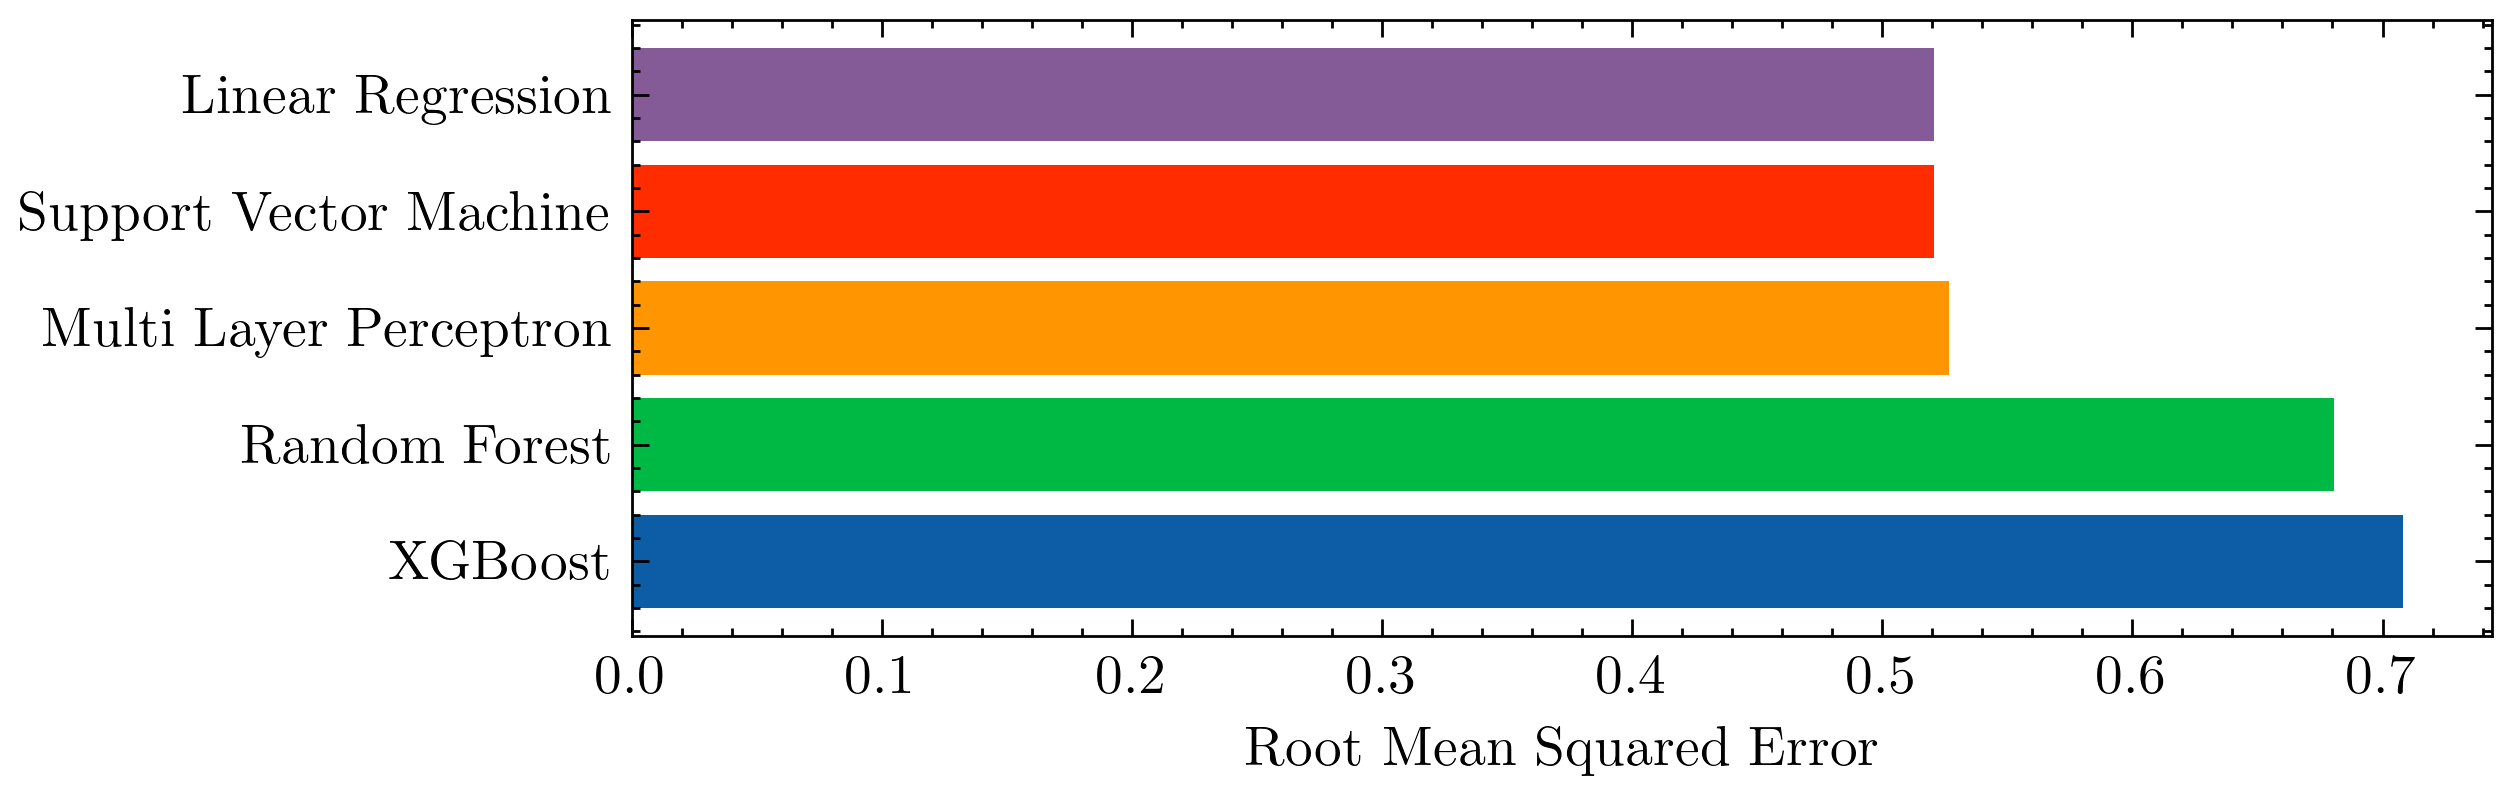

In [60]:
mean = [0, 0, 0, 0]
cov = [[1, 1, 0, 0], [1, 1, 0, 0], [0, 0, 1, 0.2], [0, 0, 0.2, 1]]
XS = np.random.multivariate_normal(mean, cov, num_samples)
X1 = XS[:, 0]
X2 = XS[:, 1]
X3 = XS[:, 2]
X4 = XS[:, 3]

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.5, num_samples)  # Adding noise
y = X1 + X2 + X3 + X4 + noise

data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)
# Splitting the dataset into training and testing sets

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
mlp_reg = MLPRegressor(hidden_layer_sizes=100, max_iter=1000)
mlp_reg.fit(X_train, y_train)
# Evaluate models
data = pd.DataFrame({"X1": X1, "X2": X2, "X3": X3, "X4": X4, "y": y})
# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
}


plot_feature_importance_comparison(
    models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

In [55]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, 2*x_vals, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-3, 3)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

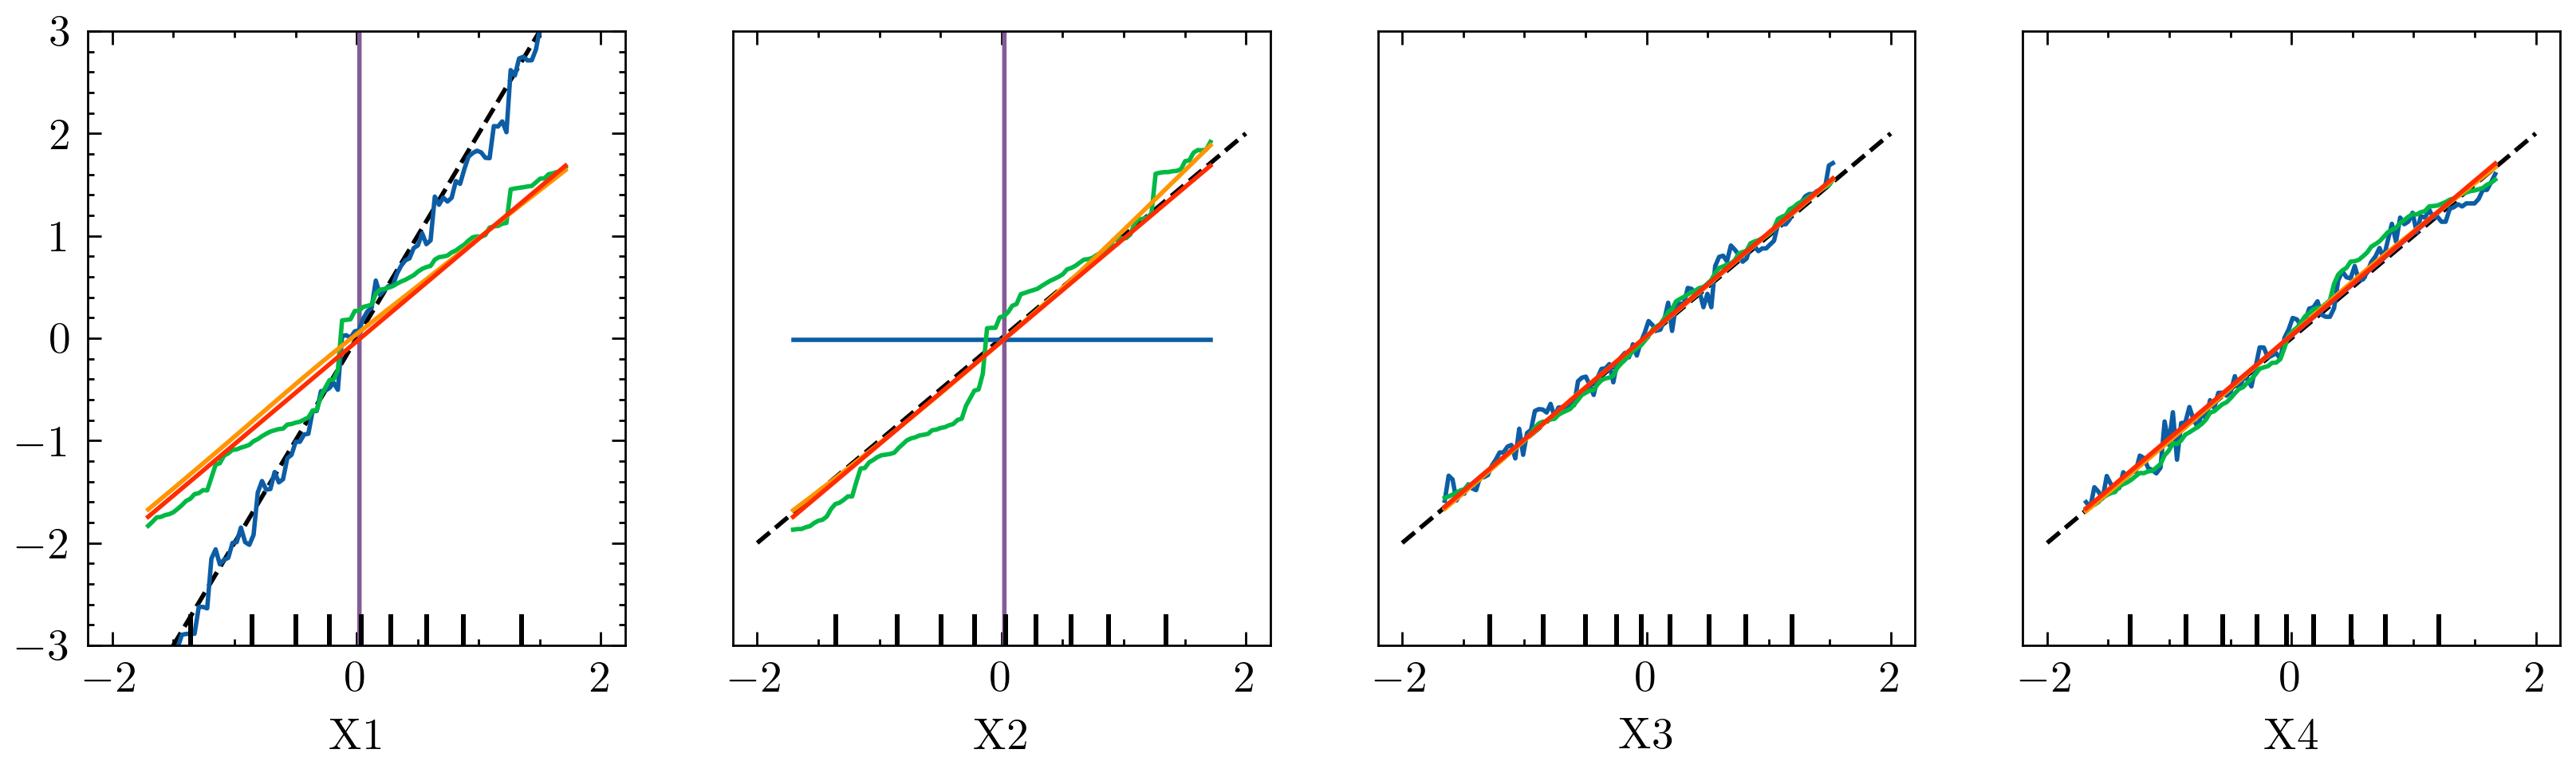

In [56]:
display(my_plot)

6.result

##  Non linear relations

7.non linear sine wave 

$ {y^i = \sin(2*x_1^i) + x_2^i + x_3^i+ x_4^i + \epsilon}$

Covariance matrix :
${\begin{bmatrix}
1 & 0 & 0& 0\\
0 & 1 & 0& 0\\
0 & 0 & 1& 0\\
0 & 0 & 0& 1\\
\end{bmatrix}}$

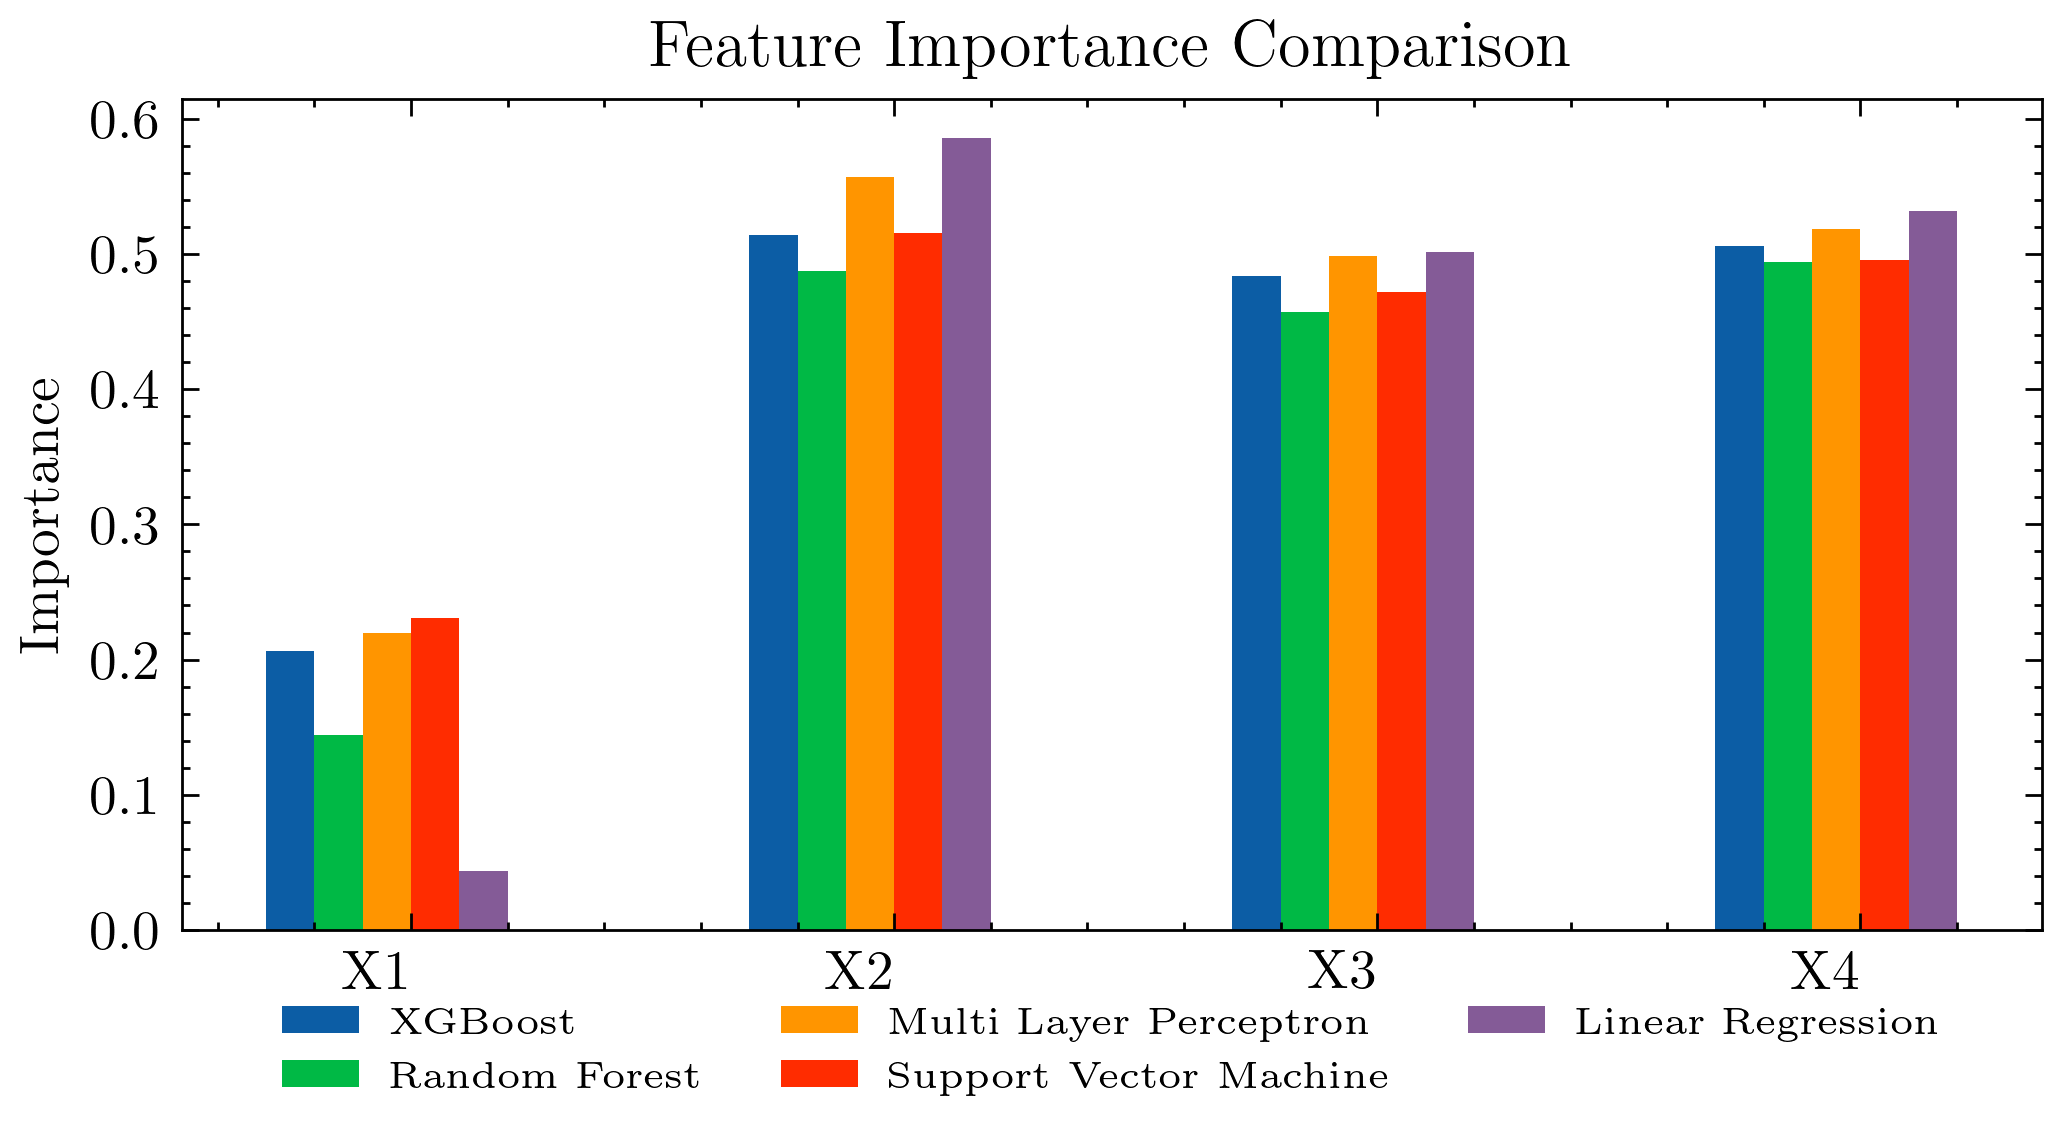

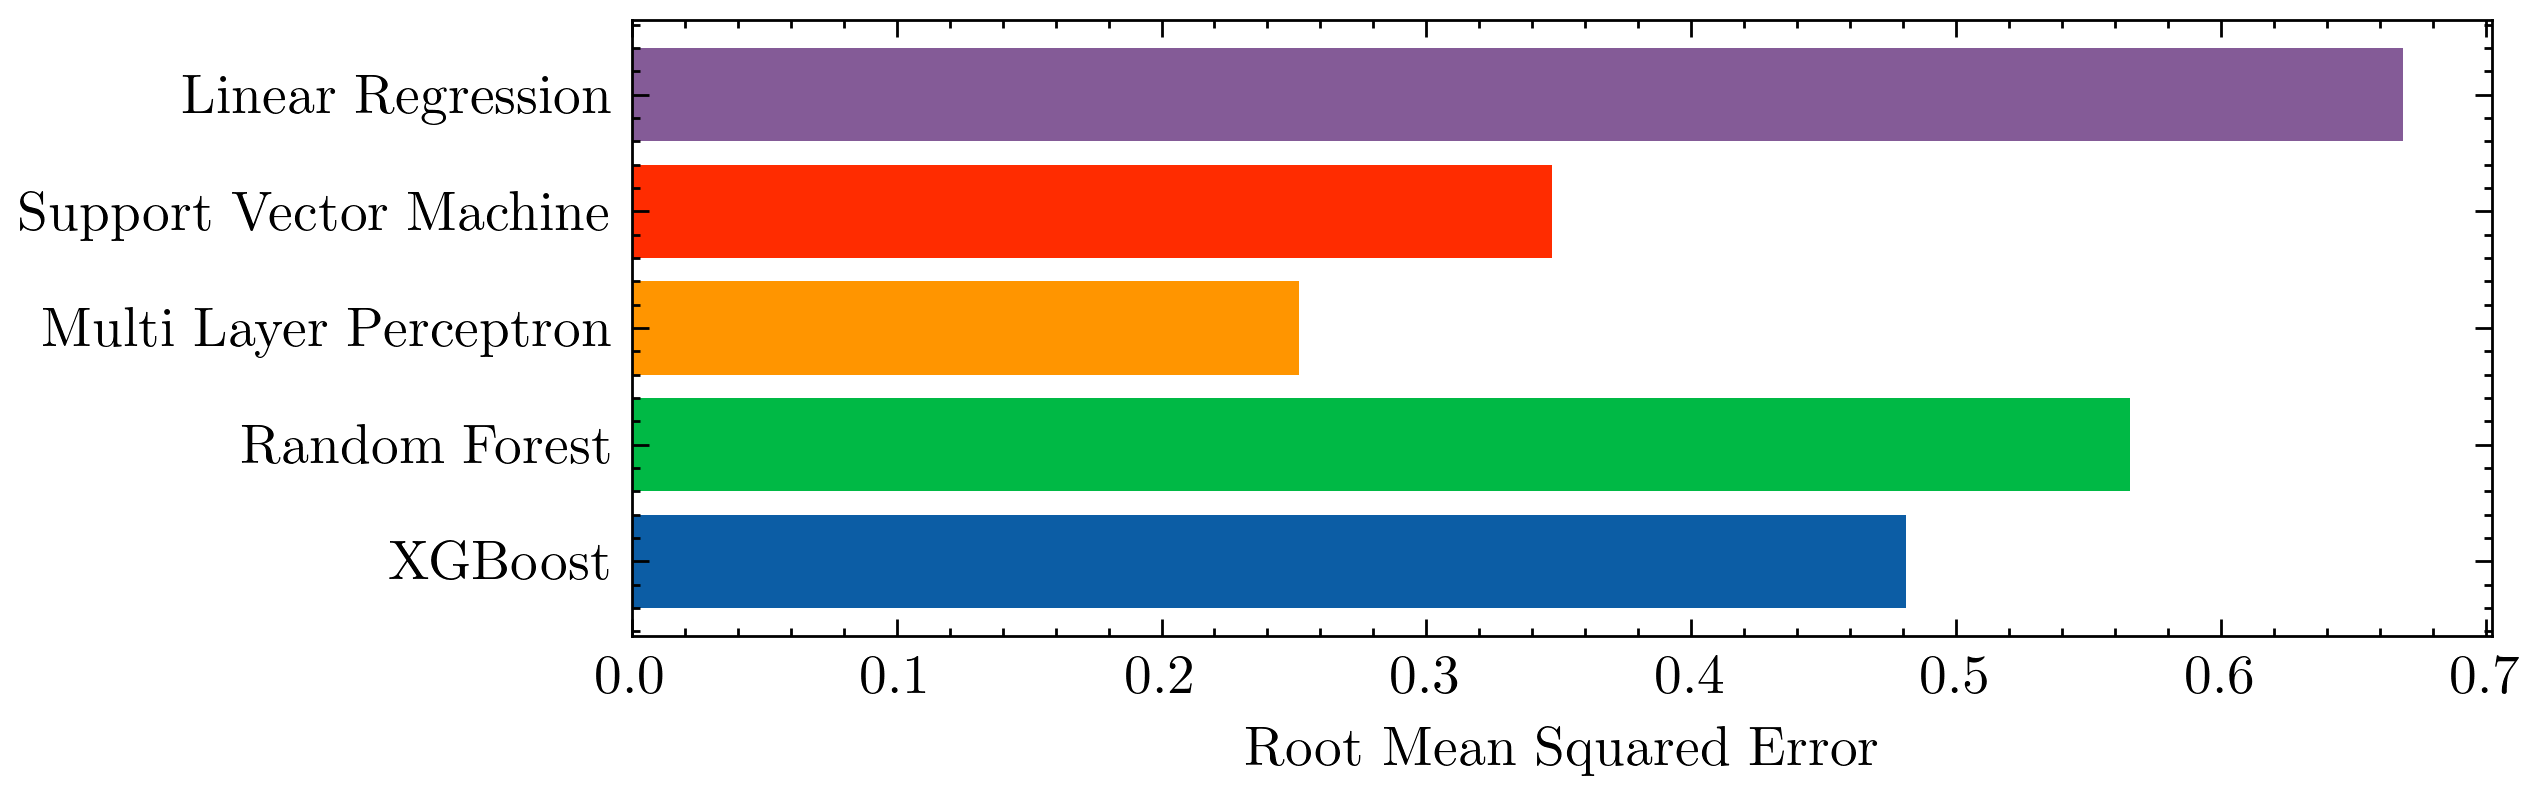

In [42]:
# Generating each feature separately
X1 = np.random.randn(num_samples)  # Feature 1
X2 = np.random.randn(num_samples)  # Feature 2
X3 = np.random.randn(num_samples)  # Feature 3
X4 = np.random.randn(num_samples)  # Feature 4

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.1, num_samples)  # Adding noise
y = np.sin(2*X1) + X2 + X3 + X4 + noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}

plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

In [43]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, np.sin(2*x_vals), label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-2, 2)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

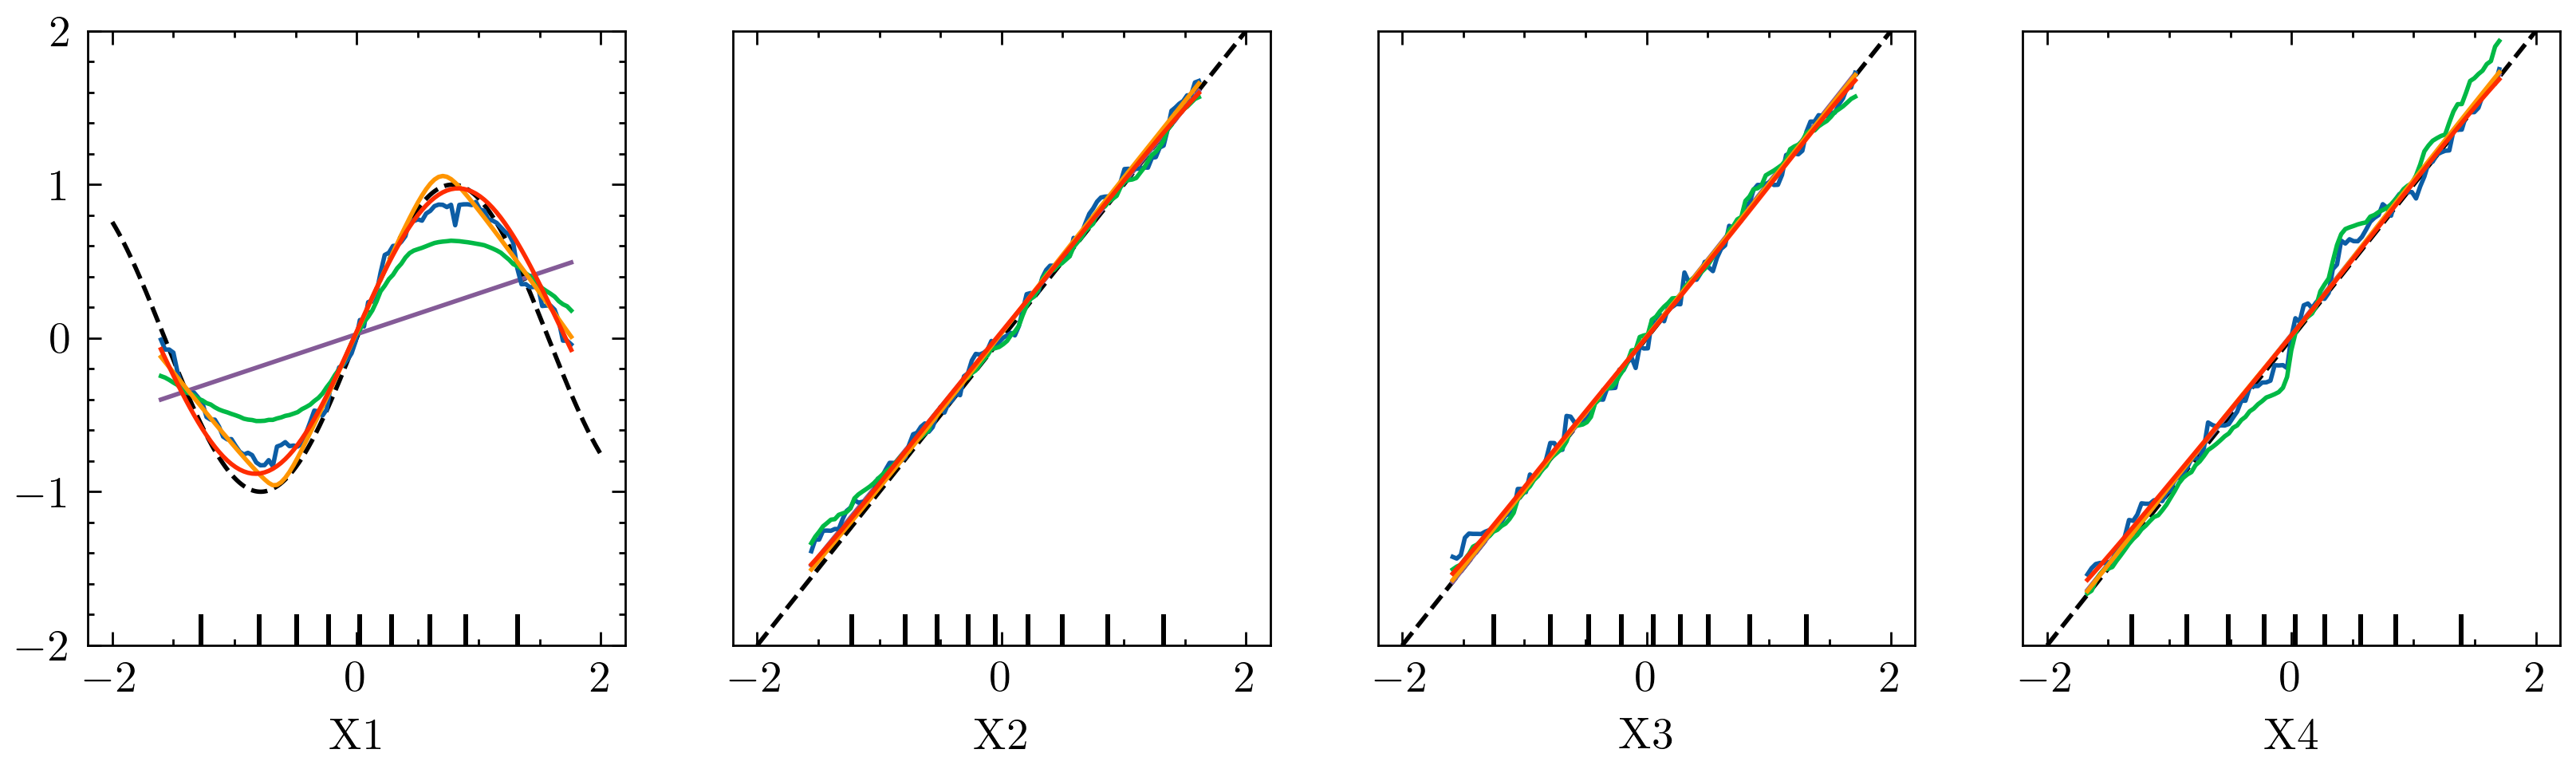

In [44]:
display(my_plot)

8.non linear correlation

$ {y^i = \sin(2*x_1^i) + x_2^i + x_3^i+ 0*x_4^i + \epsilon}$

Covariance matrix :
${\begin{bmatrix}
1 & 0.95 & 0& 0\\
0.95 & 1 & 0& 0\\
0 & 0 & 1& 0\\
0 & 0 & 0& 1\\
\end{bmatrix}}$

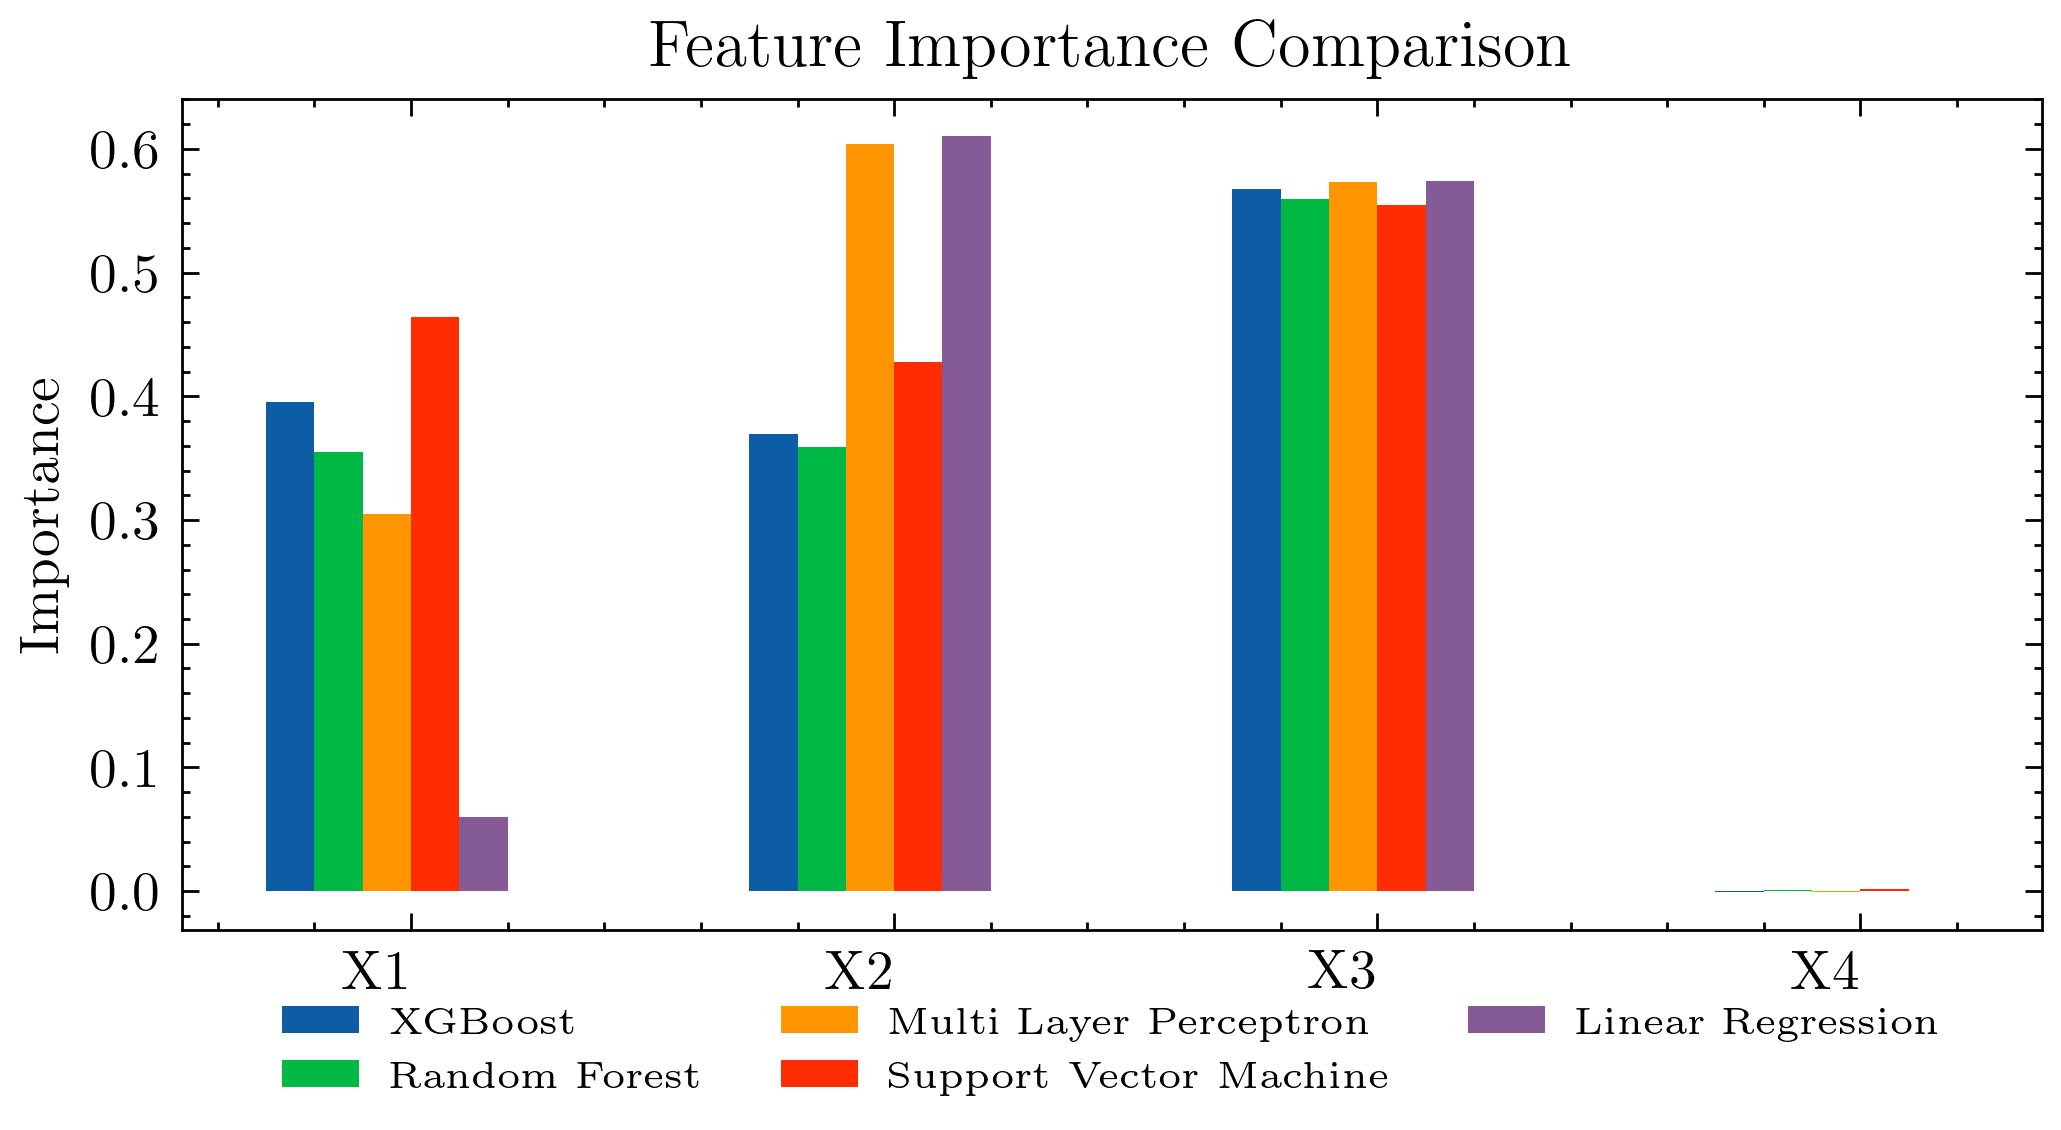

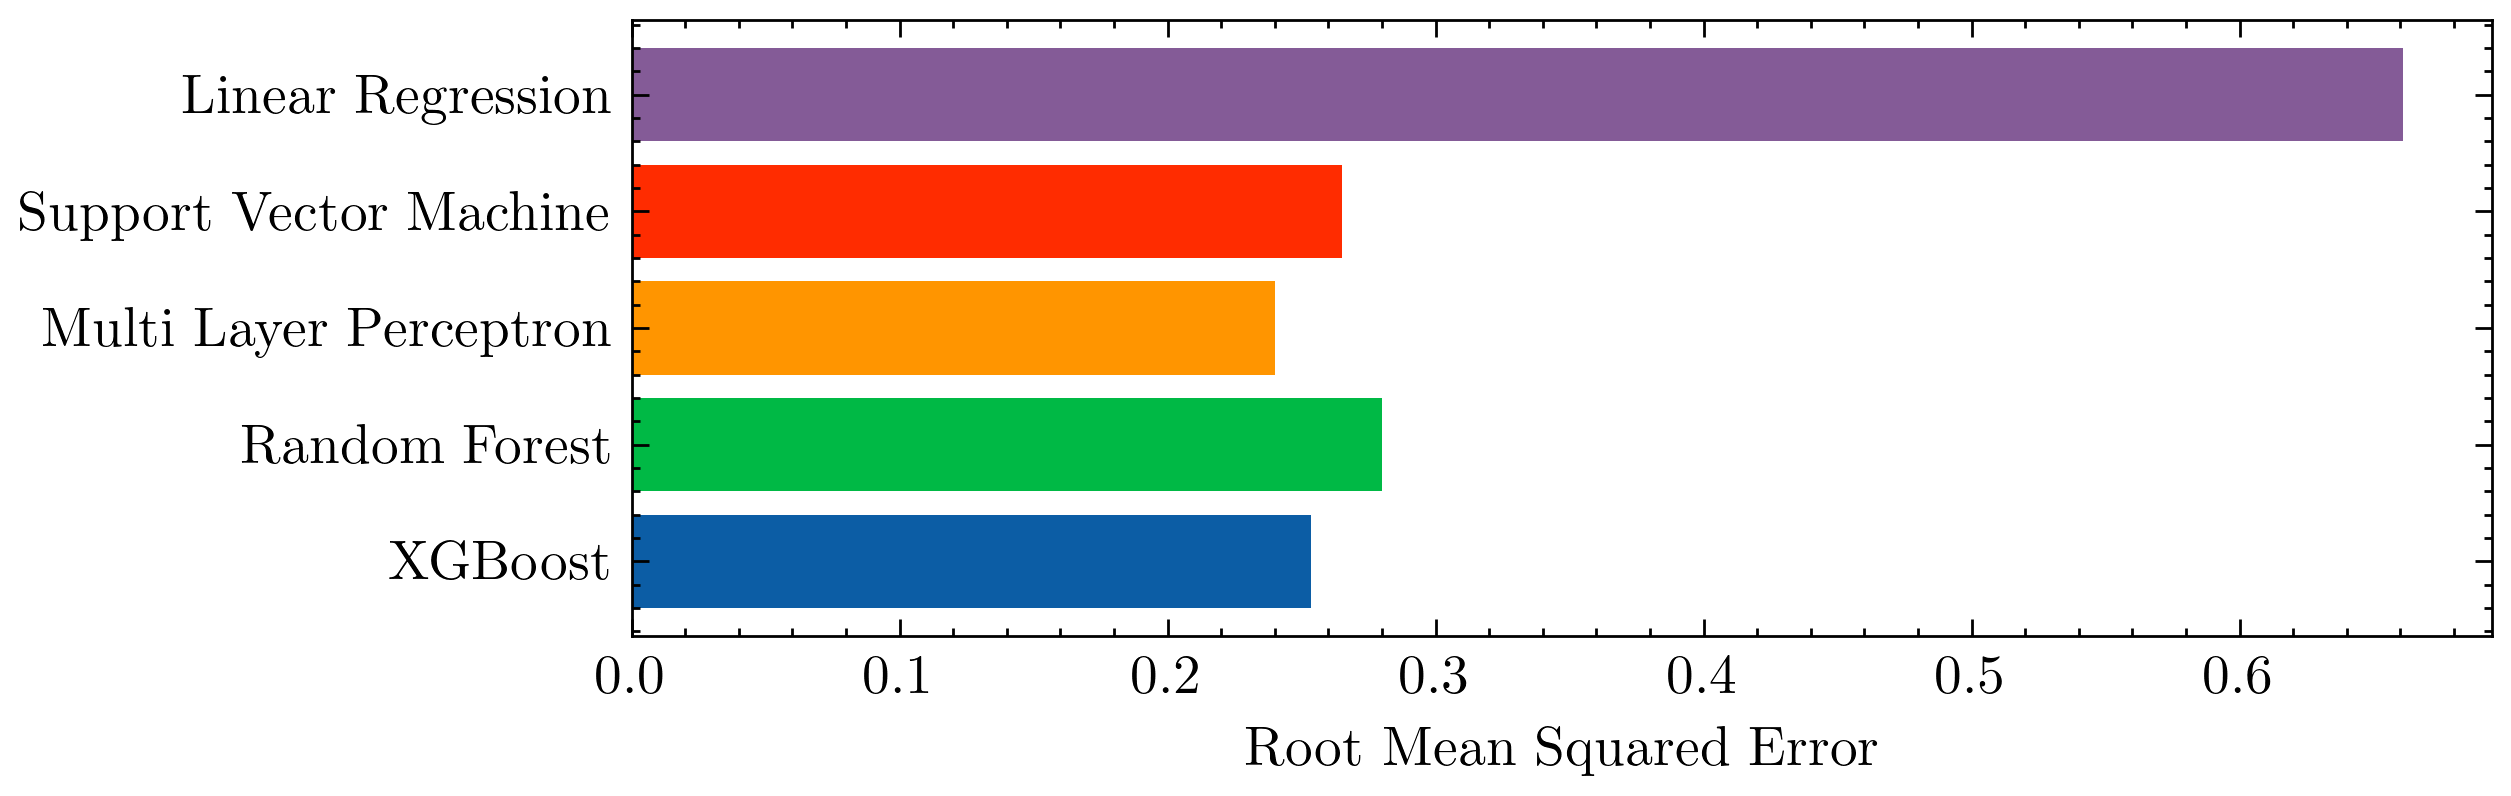

In [48]:
mean = [0, 0, 0, 0]
cov = [[1, 0.95, 0, 0], [0.95, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
XS = np.random.multivariate_normal(mean, cov, num_samples)
X1 = XS[:, 0]
X2 = XS[:, 1]
X3 = XS[:, 2]
X4 = XS[:, 3]

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.1, num_samples)  # Adding noise
y = np.sin(2*X1) + X2 + X3  + noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}

plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

In [46]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, np.sin(2*x_vals), label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, 0*x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-2, 2)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

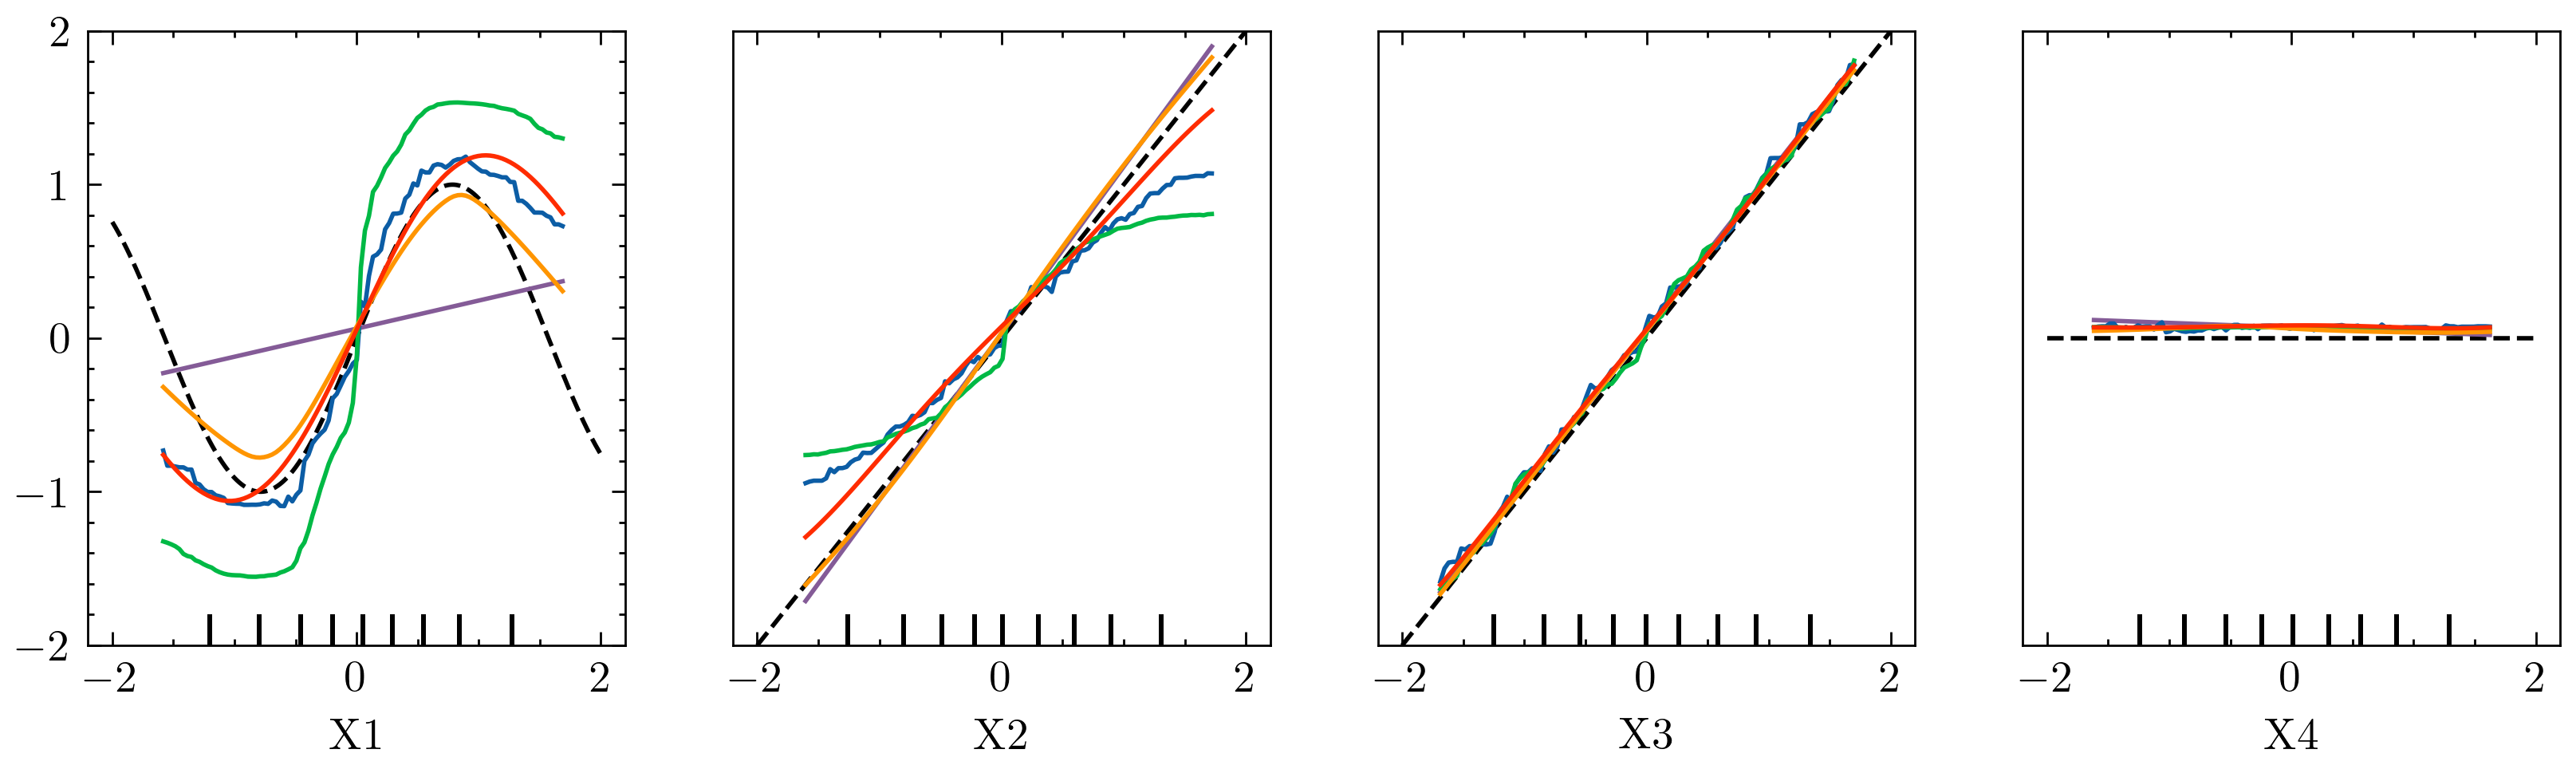

In [47]:
display(my_plot)

Feature interaction

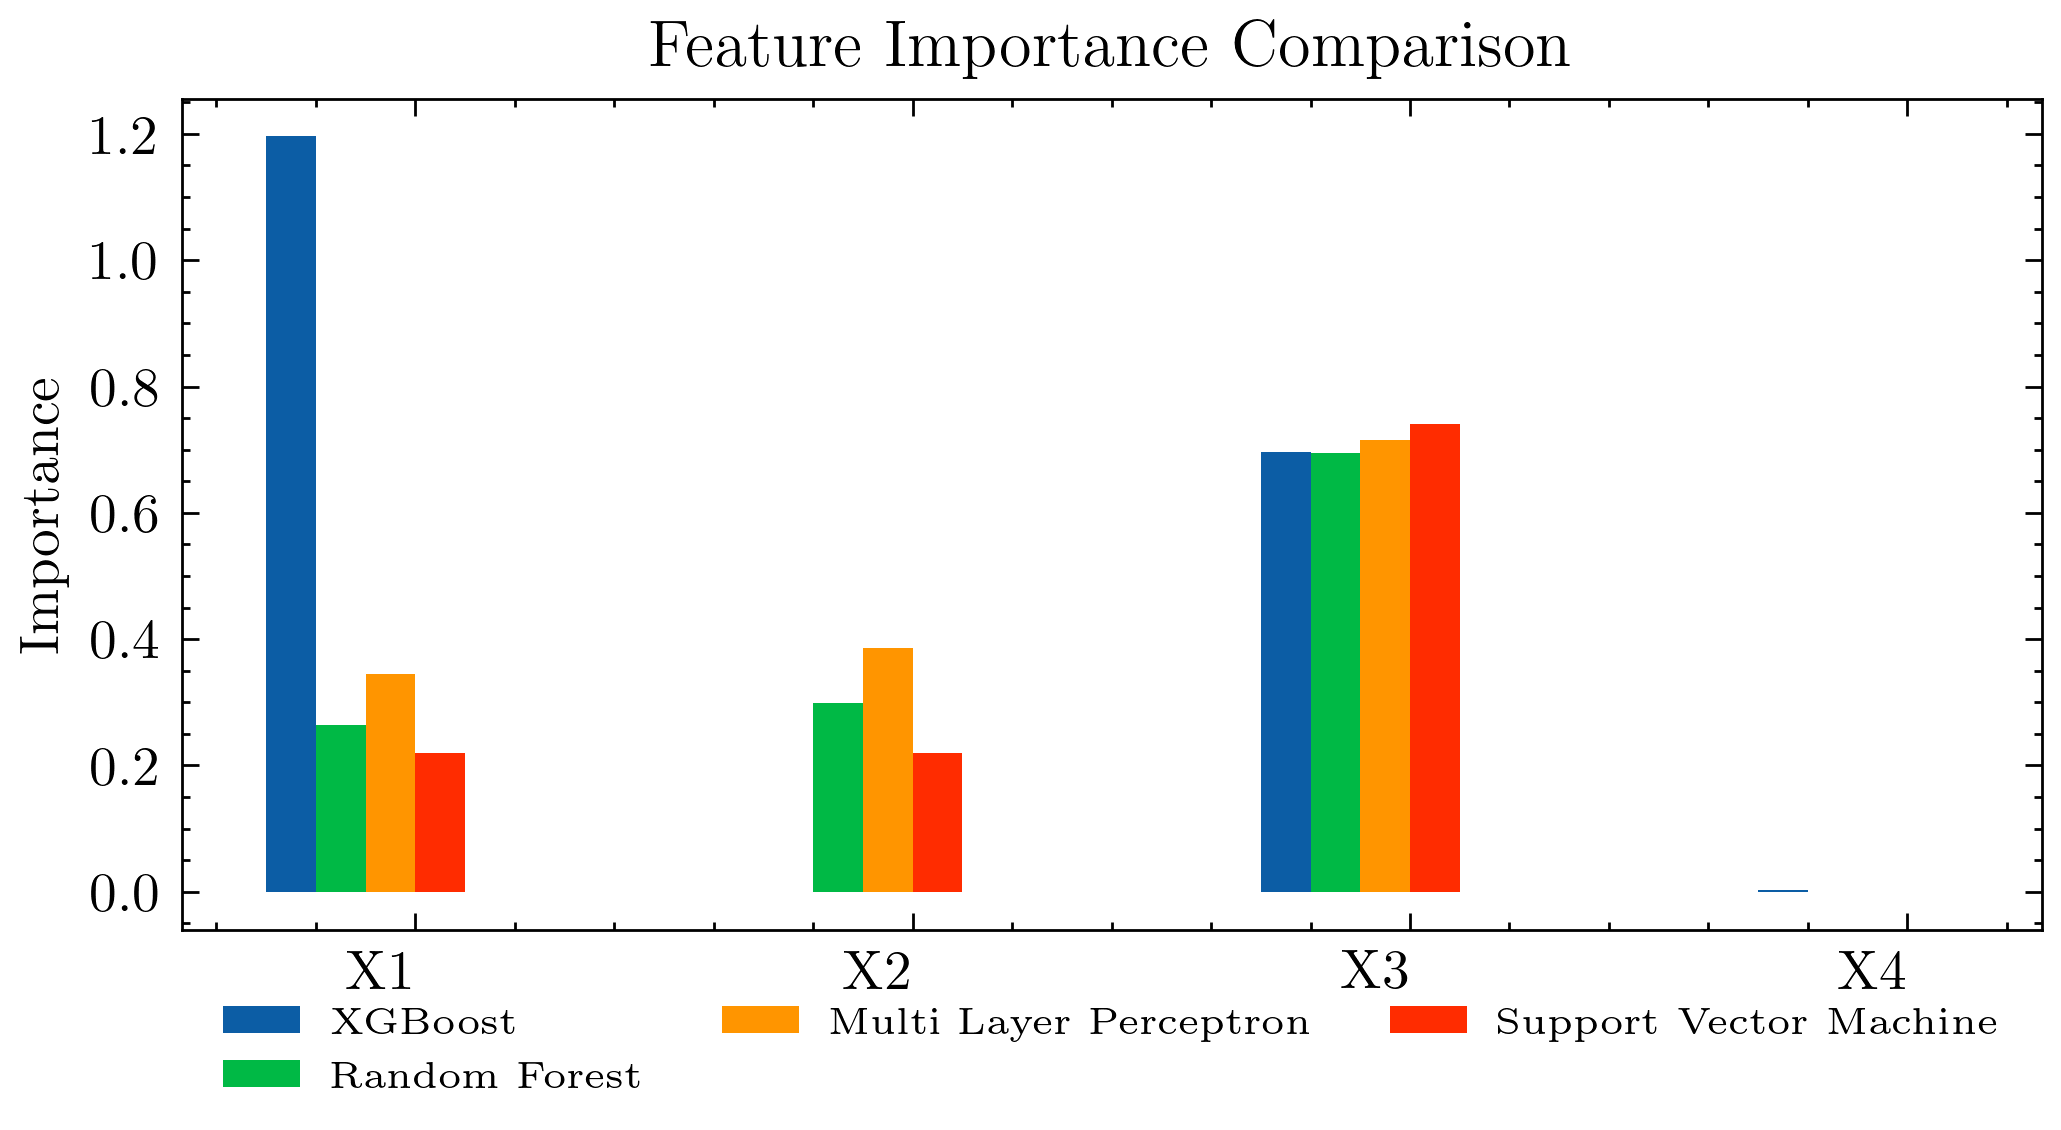

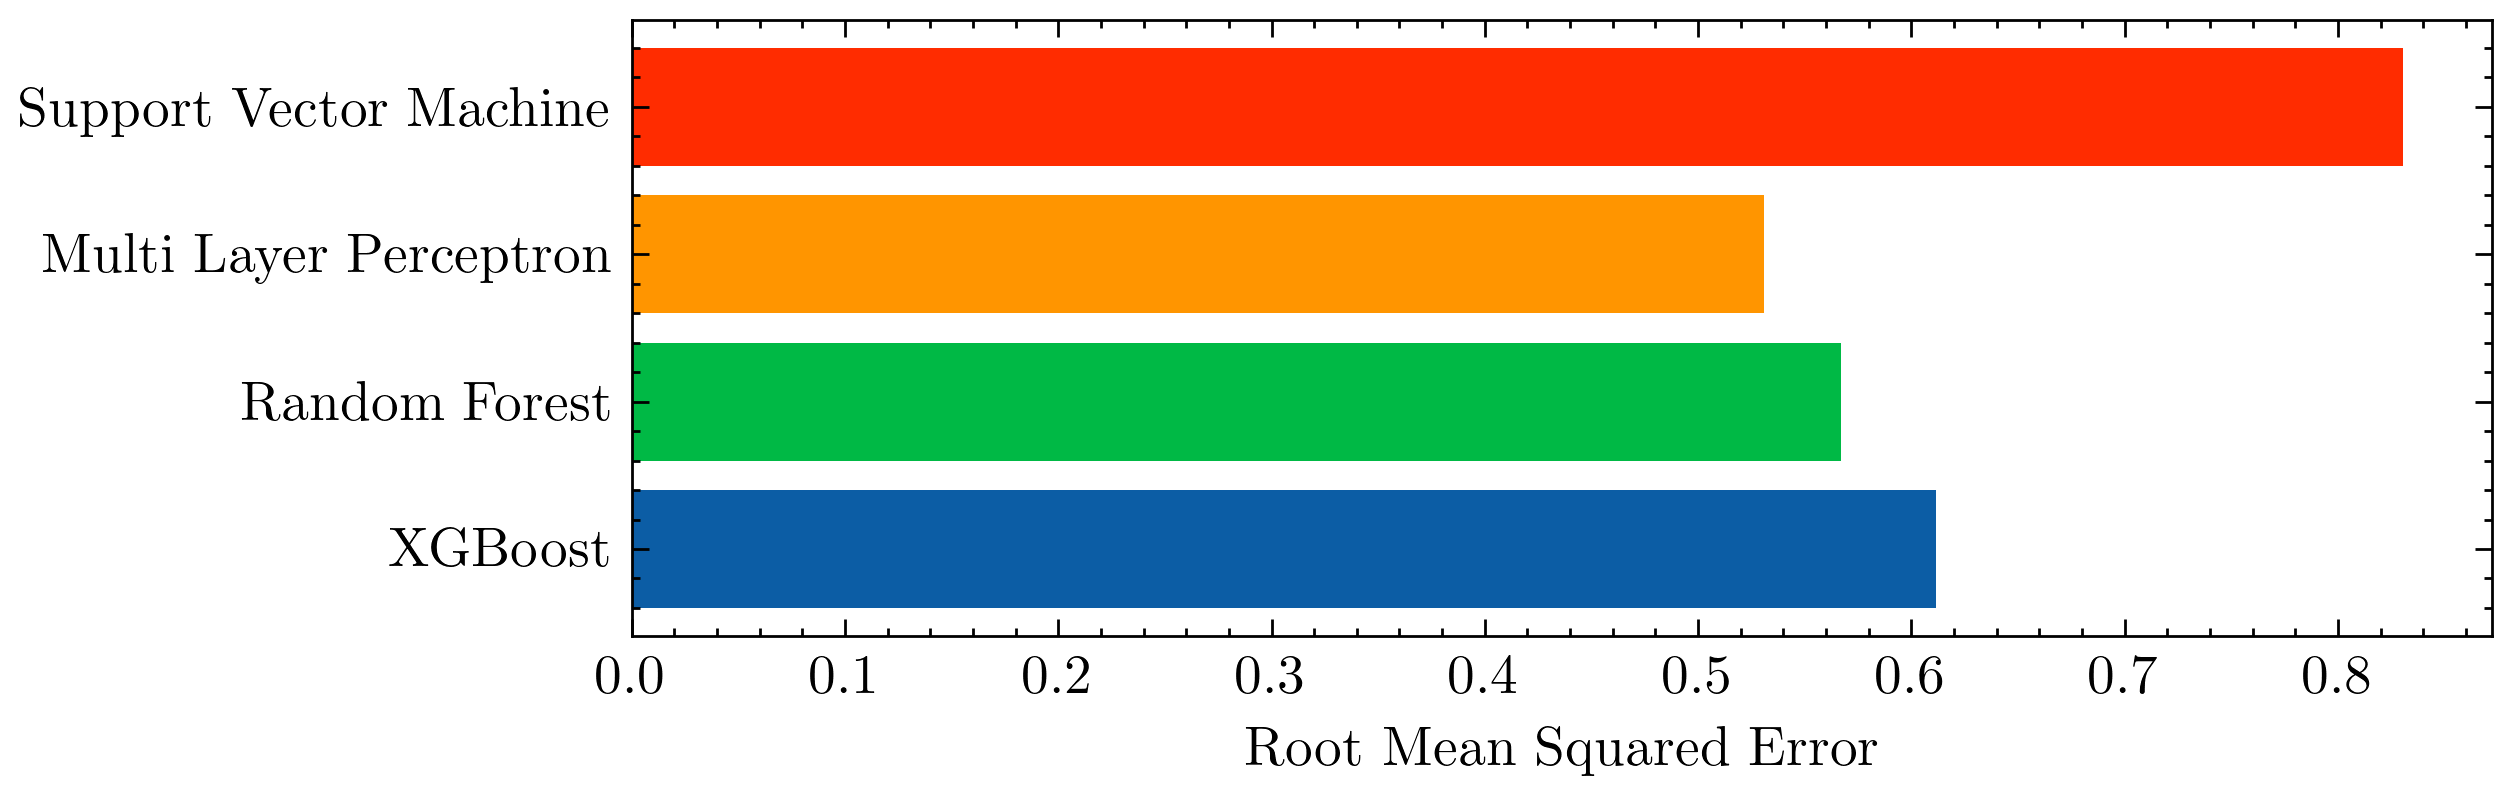

In [57]:
mean = [0, 0, 0, 0]
cov = [[1, 1, 0, 0], [1, 1, 0, 0], [0, 0, 1, 0.2], [0, 0, 0.2, 1]]
XS = np.random.multivariate_normal(mean, cov, num_samples)
X1 = XS[:, 0]
X2 = XS[:, 1]
X3 = XS[:, 2]
X4 = XS[:, 3]

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.5, num_samples)  # Adding noise
y = np.sin(2*X1) + X2 + X3  + noise

data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123)
# Splitting the dataset into training and testing sets

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
mlp_reg = MLPRegressor(hidden_layer_sizes=100, max_iter=1000)
mlp_reg.fit(X_train, y_train)
# Evaluate models
data = pd.DataFrame({"X1": X1, "X2": X2, "X3": X3, "X4": X4, "y": y})
# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
}


plot_feature_importance_comparison(
    models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

In [58]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, x_vals + np.sin(2*x_vals), label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, 0*x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-2, 2)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig


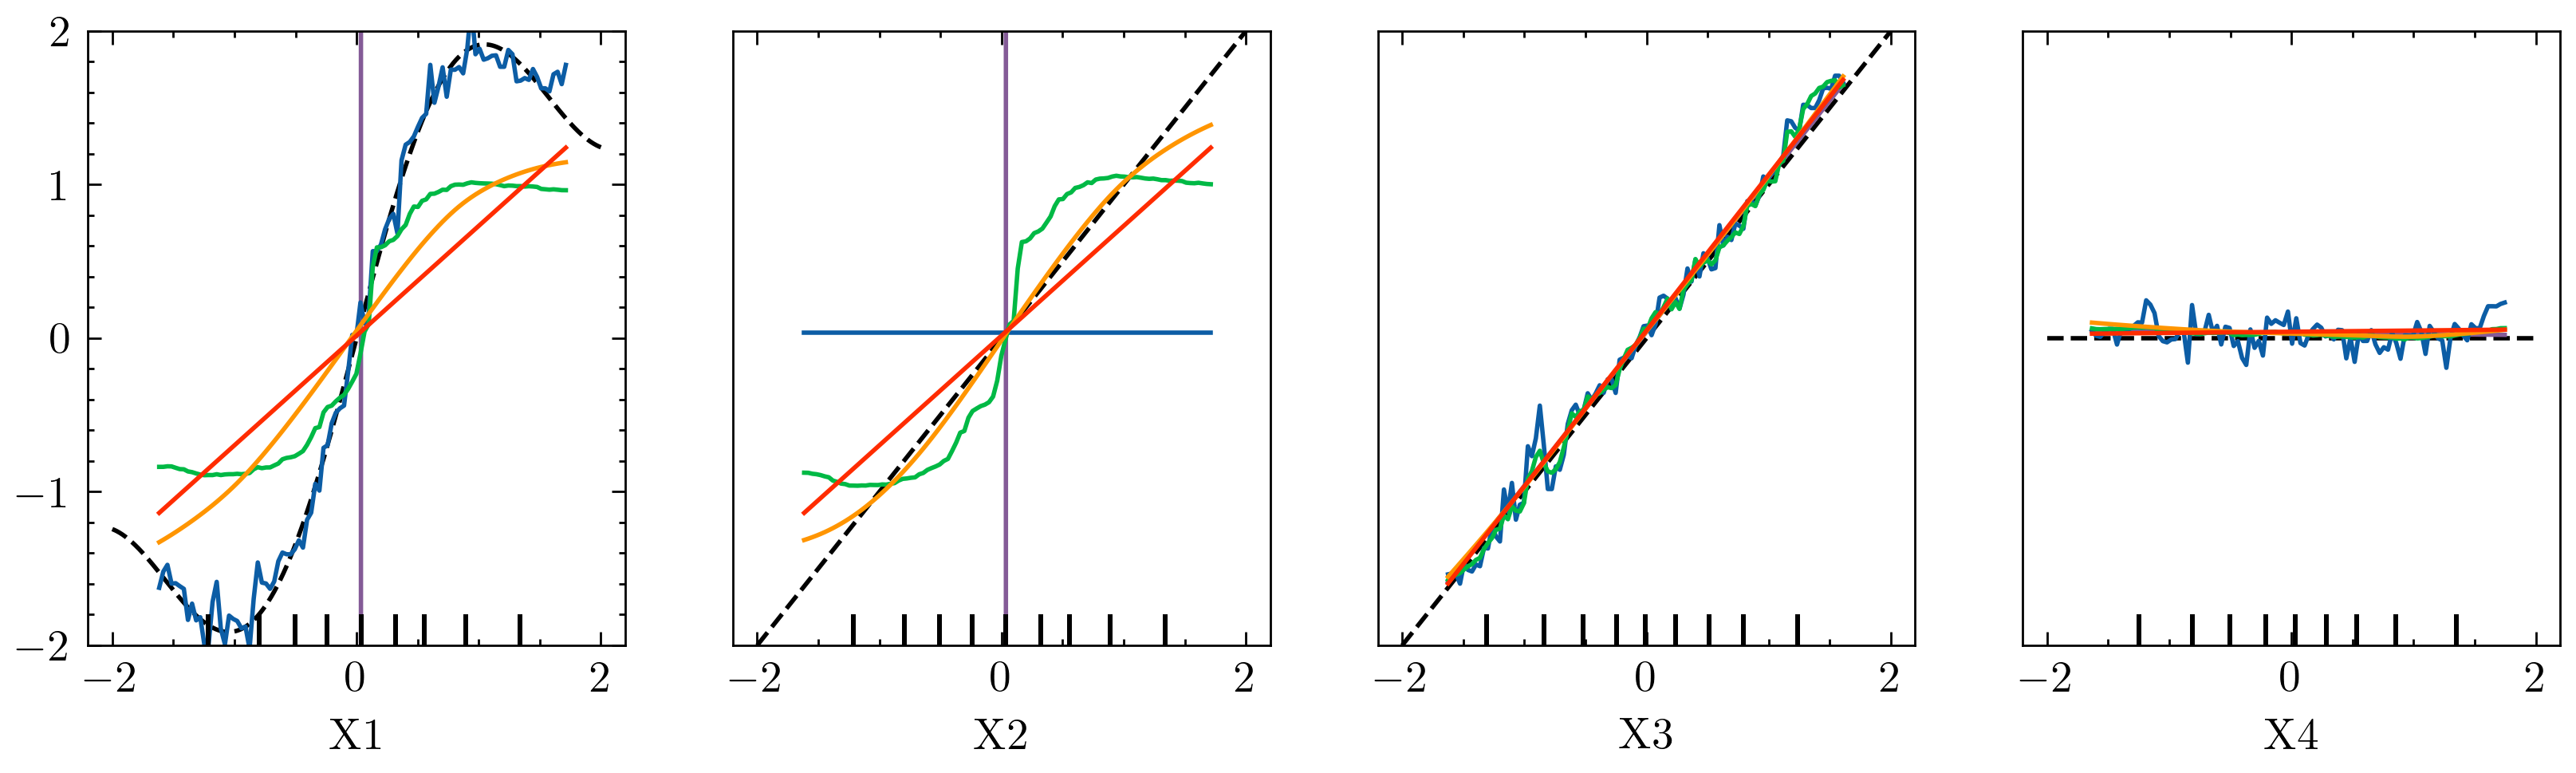

In [59]:
display(my_plot)

8.Polynomial and exponential

$ {Y = X_1 + X_1 * X_1 + \exp(X_3) + X_4}$


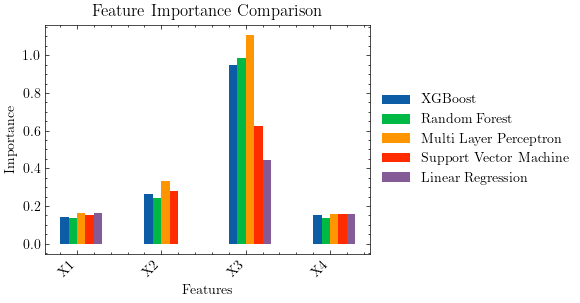

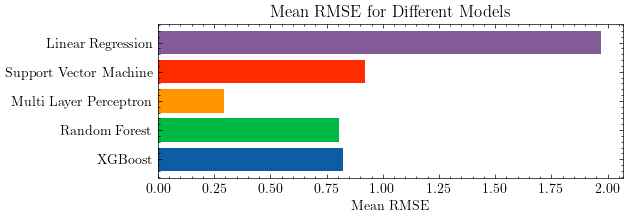

In [46]:
mean = [0, 0, 0, 0]
cov = [[1, 0, 0, 0.2], [0, 1, 0, 0], [0, 0, 1, 0], [0.2, 0, 0, 1]]
XS = np.random.multivariate_normal(mean, cov, num_samples)
X1 = XS[:, 0]
X2 = XS[:, 1]
X3 = XS[:, 2]
X4 = XS[:, 3]

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.1, num_samples)  # Adding noise
y = X1 + (X2*X2) + np.exp(X3)  + X4+ noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}
plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

In [47]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, x_vals , label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals * x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, np.exp(x_vals), label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-3, 7)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

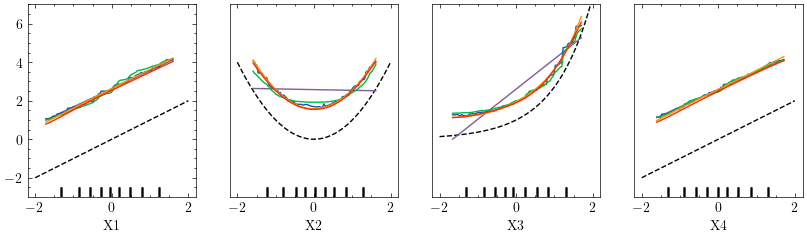

In [48]:
display(my_plot)

9.exponential interaction

$ {Y = X_1 + X_2 + \exp(X_3) * X_4 + \epsilon}$


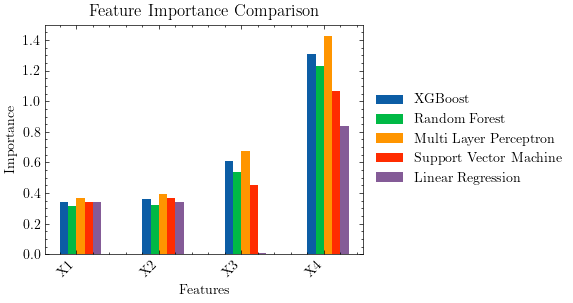

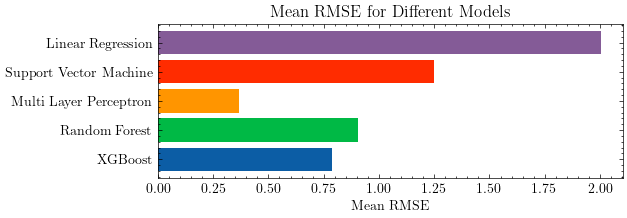

In [49]:
mean = [0, 0, 0, 0]
cov = [[1, 0, 0, 0],
       [0, 1, 0, 0], 
       [0, 0, 1, 0], 
       [0, 0, 0, 1]]
XS = np.random.multivariate_normal(mean, cov, num_samples)
X1 = XS[:, 0]
X2 = XS[:, 1]
X3 = XS[:, 2]
X4 = XS[:, 3]

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.1, num_samples)  # Adding noise
y = X1 + X2 + np.exp(X3) * X4+ noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})
# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=2000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}

plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

In [50]:
%%capture
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    ax1.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, np.exp(x_vals) *x_vals , label='true effect', color='black',linestyle='dashed')
    ax4.plot(x_vals, np.exp(x_vals) *x_vals, label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})
    for ax in [ax1, ax2, ax3, ax4]:
        ax.get_legend().remove()
        ax.set_ylim(-4, 4)
        ax.set_ylabel('')  
    for ax in [ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique
    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)
    my_plot = fig

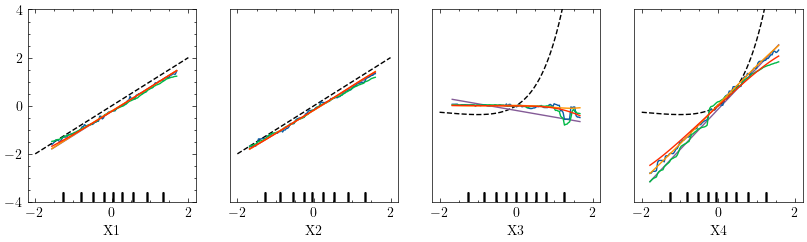

In [51]:
display(my_plot)

9 . with categorical 



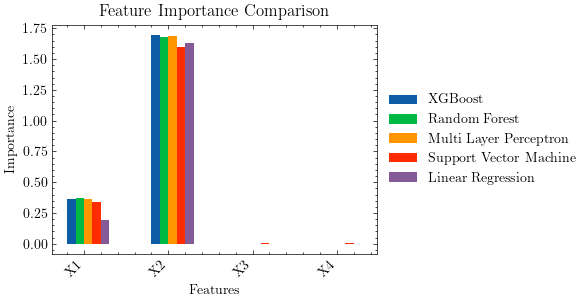

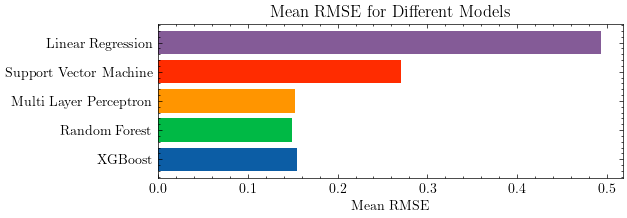

In [52]:
mean = [0, 0, 0, 0]
cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
XS = np.random.multivariate_normal(mean, cov, num_samples)
X1 = XS[:, 0]
X2 = XS[:, 1]
X3 = XS[:, 2]
X4 = XS[:, 3]

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.1, num_samples)  # Adding noise
p = 0.6
X1 = np.random.choice([0,1],size=num_samples,p=[p,1-p])
y = X1 + X2 +  (X1* X2)+ noise

# Creating a DataFrame
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})
# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

# Splitting the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Multi-layer Perceptron Regression
mlp_reg = MLPRegressor(hidden_layer_sizes=(100), max_iter=1000, random_state=42)
mlp_reg.fit(X_train, y_train)

# Example usage with custom colors
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'Multi Layer Perceptron': mlp_reg,
    'Support Vector Machine': svm_reg,
    "Linear Regression":linear_reg
}

plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors)
plot_feature_mean_squared_error(models,X_train,y_train,custom_colors)

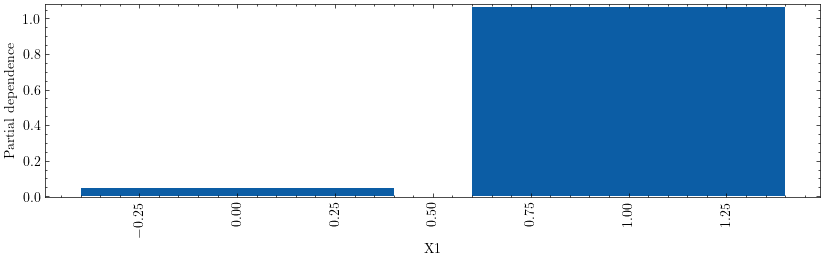

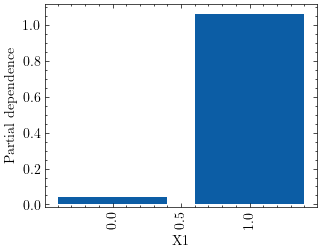

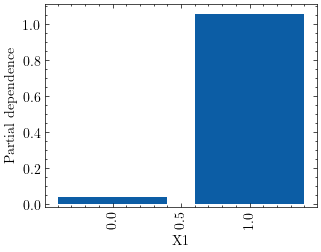

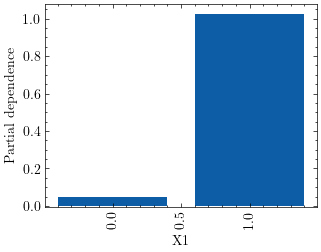

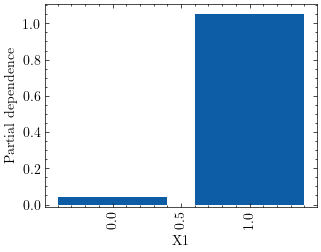

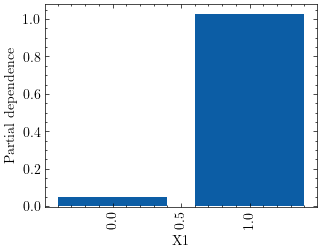

In [53]:
from sklearn.inspection import PartialDependenceDisplay
my_plot = None
with plt.style.context('science'):
    fig,(ax1) = plt.subplots(1, 1, figsize=(10, 2.5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0],feature_names=["X1"],categorical_features=["X1"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0],feature_names=["X1"],categorical_features=["X1"])
    rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0],feature_names=["X1"],categorical_features=["X1"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0],feature_names=["X1"],categorical_features=["X1"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0],feature_names=["X1"],categorical_features=["X1"])
    lr_disp.plot(ax=[ax1], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1], line_kw={"label": "NN","color":custom_colors[2]})
    svm_disp.plot(ax=[ax1], line_kw={"label": "SVM","color":custom_colors[3]})

## Others

Simulation 3 : dependent features

C:\Users\versu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


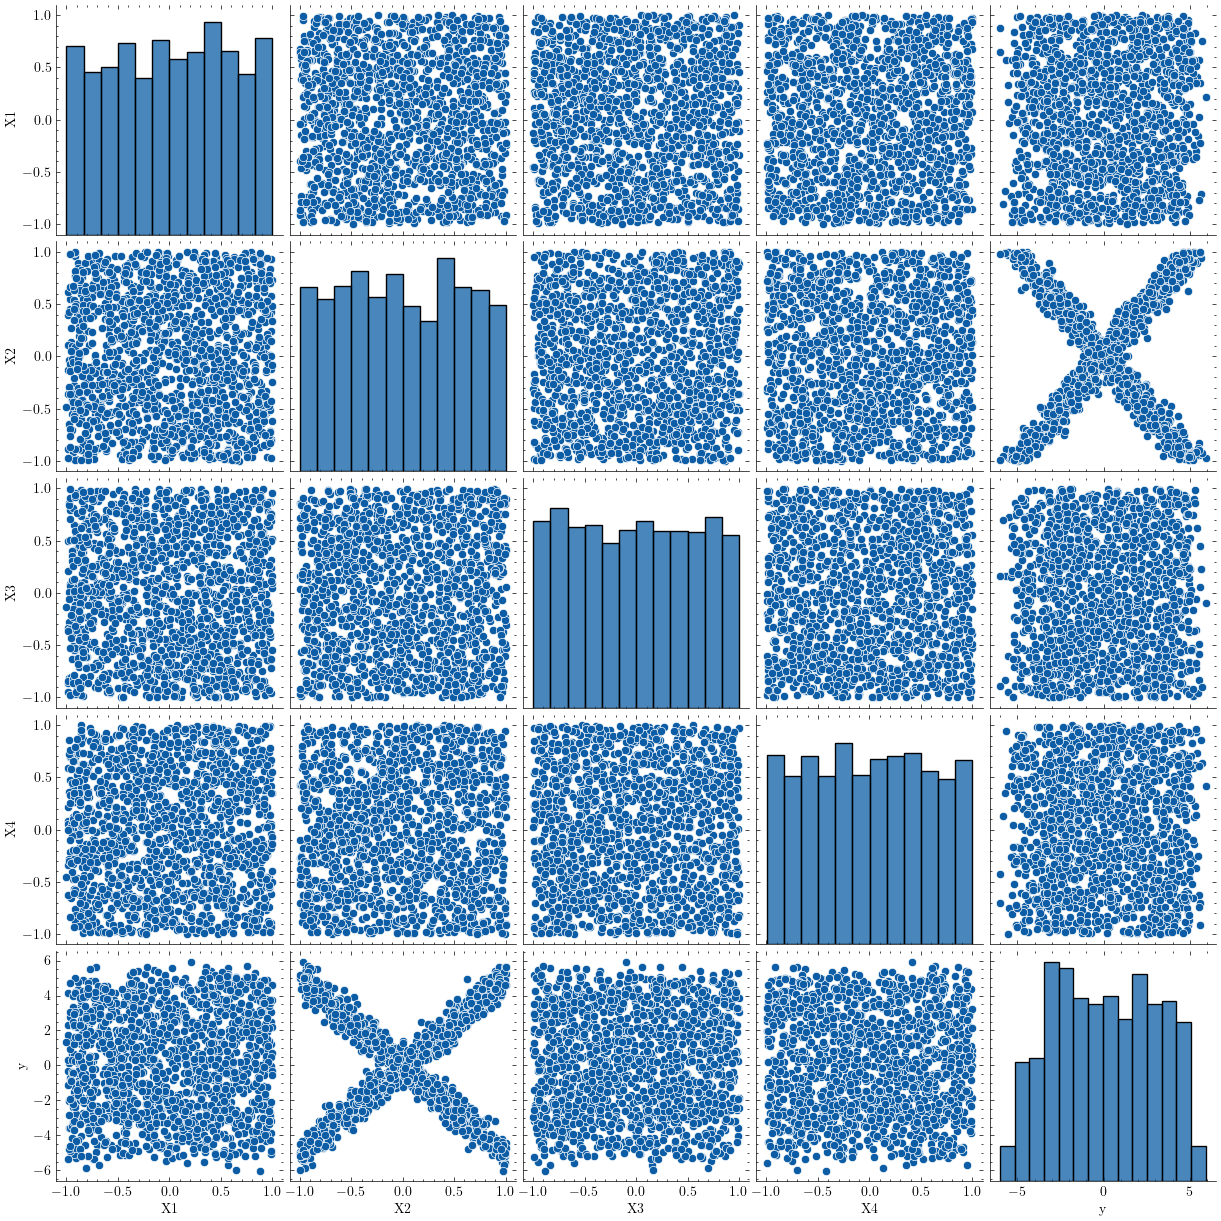

In [54]:

# Generating random values for x1, x2, and x3 where x3 is between -1 and 1
x1 = np.random.uniform(-1, 1, num_samples)
x2 = np.random.uniform(-1, 1, num_samples)
x3 = np.random.uniform(-1, 1, num_samples)
x4 = np.random.uniform(-1, 1, num_samples)


# Generating random values for the error term e from a normal distribution
e = np.random.normal(0, 0.5, num_samples)

# Calculate y based on the equation with x3 values above 0
condition = x3 > 0
y = 0.2 * x1 - 5 * x2 + np.where(condition, 10 * x2, 0) + e

df = pd.DataFrame({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4,'y':y})
X = df[['X1', 'X2', 'X3', 'X4']]
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize and fit the models
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

xgb_model = XGBRegressor()
xgb_model.fit(X_train,y_train)

svm_model = SVR(kernel='rbf')
svm_model.fit(X_train,y_train)

rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train,y_train)

mlp_reg = MLPRegressor(hidden_layer_sizes=50,max_iter=1000)
mlp_reg.fit(X_train,y_train)
# Predict y values using the fitted models
y_pred_linear = linear_model.predict(X)
y_pred_xgb = xgb_model.predict(X)
y_pred_svm = svm_model.predict(X)
y_pred_rf = rf_model.predict(X)
sns.pairplot(df)


TypeError: Legend.__init__() got an unexpected keyword argument 'legend'

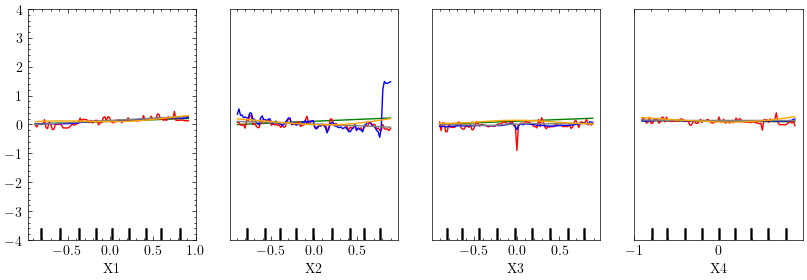

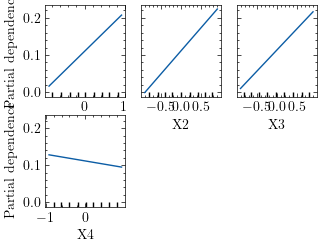

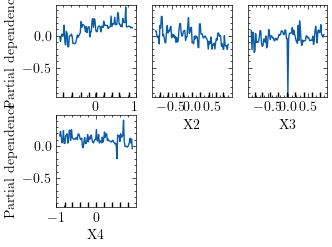

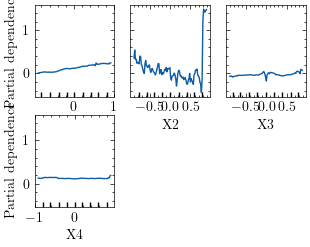

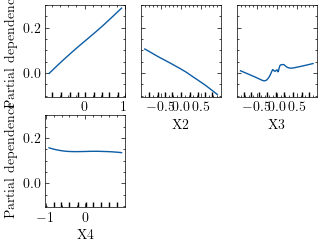

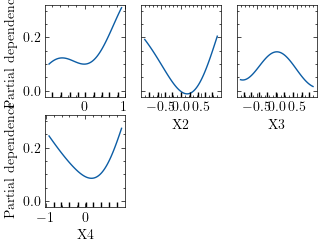

In [55]:
from sklearn.inspection import PartialDependenceDisplay

fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(10, 3))  # (rows, columns, index)
lr_disp = PartialDependenceDisplay.from_estimator(linear_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":'green'})
xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":'red'})
rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":'blue'})
mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":'grey'})
svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":'orange'})
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(-4, 4)
    ax.set_ylabel('')  
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([])
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return unique

lines_labels = legend_without_duplicate_labels(ax1)
lines, labels = zip(*lines_labels)
lines = list(lines)
labels = list(labels)

fig.legend(lines, labels, fontsize='small',legend=False)
plt.show()

In [ ]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(
    1, 4, figsize=(20, 6))  # (rows, columns, index)
PartialDependenceDisplay.from_estimator(linear_model, X, features=[
                                               0, 1,2,3], feature_names=["x", "x2","x3","x4"], ax=[ax1, ax2,ax3,ax4],kind='both')
fig, (ax1, ax2,ax3,ax4) = plt.subplots(
    1, 4, figsize=(20, 6))  # (rows, columns, index)
PartialDependenceDisplay.from_estimator(xgb_model, X, features=[
                                               0, 1,2,3], feature_names=["x", "x2","x3","x4"], ax=[ax1, ax2,ax3,ax4],kind='both')
fig, (ax1, ax2,ax3,ax4) = plt.subplots(
    1, 4, figsize=(20, 6))  # (rows, columns, index)
PartialDependenceDisplay.from_estimator(svm_model, X, features=[
                                               0, 1,2,3], feature_names=["x", "x2","x3","x4"], ax=[ax1, ax2,ax3,ax4],kind='both')
fig, (ax1, ax2,ax3,ax4) = plt.subplots(
    1, 4, figsize=(20, 6))  # (rows, columns, index)
PartialDependenceDisplay.from_estimator(rf_model, X, features=[
                                               0, 1,2,3], feature_names=["x", "x2","x3","x4"], ax=[ax1, ax2,ax3,ax4],kind='both')
fig, (ax1, ax2,ax3,ax4) = plt.subplots(
    1, 4, figsize=(20, 6))  # (rows, columns, index)
PartialDependenceDisplay.from_estimator(mlp_reg, X, features=[
                                               0, 1,2,3], feature_names=["x", "x2","x3","x4"], ax=[ax1, ax2,ax3,ax4],kind='both')


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pylab as plt
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 10))  # (rows, columns, index)
lr_disp = PartialDependenceDisplay.from_estimator(linear_model, X, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_model, X, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_model, X, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
mlrp_disp = PartialDependenceDisplay.from_estimator(mlp_reg, X, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_model, X, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])


lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":'green'})
xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":'red'})
rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":'blue'})
mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":'grey'})
svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":'orange'})


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
from dython.nominal import associations  # correlation calculation
from sklearn.linear_model import Lasso

# Generating synthetic regression data with dependent features and noise
np.random.seed(123)
num_samples = 1500

X1 = np.random.randn(num_samples)
X2 = X1.copy()
X3 = np.random.randn(num_samples)

X4 = np.random.randn(num_samples)

noise = np.random.normal(0, 0.5, num_samples)  # Adding noise

y = X1 + X1 * 1.1 + 1.2* X3 + noise
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=123)
rf_reg.fit(X_train, y_train)
# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(random_state=123)
xgb_reg.fit(X_train, y_train)
mlpr_model = MLPRegressor(hidden_layer_sizes=100,max_iter=1000)
mlpr_model.fit(X_train, y_train)
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'MLP': mlp_reg,
    'SVR': svm_reg,
}
linear_regression_model = linear_reg 


plot_feature_importance_comparison(models, X_test, y_test, linear_reg=linear_regression_model, colors=custom_colors)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def plot_mse(models, model_names, X_train, X_test, y_train, y_test):
    train_mse = []
    train_r2 = []
    test_mse = []
    test_r2 = []
    
    for model in models:
        # Calculate MSE for training set
        y_train_pred = model.predict(X_train)
        train_mse.append(mean_squared_error(y_train, y_train_pred))
        train_r2.append(r2_score(y_train, y_train_pred))

        # Calculate MSE for test set
        y_test_pred = model.predict(X_test)
        test_mse.append(mean_squared_error(y_test, y_test_pred))
        test_r2.append(r2_score(y_test, y_test_pred))

    # Create index for the models
    x = np.arange(len(model_names))

    # Plotting
    plt.figure(figsize=(8, 2))

    marker_size = 50

    plt.scatter(x, train_mse, s=marker_size, color='b', label='Train set', marker='x')
    plt.scatter(x, test_mse, s=marker_size, color='r', label='Test set', marker='x')
    plt.ylabel('mean squared error')
    plt.xticks(x, model_names)
    plt.legend()

    plt.tight_layout()
    plt.show()
# Assuming you have X_train, X_test, y_train, y_test already defined

# List of models
models = [linear_reg, rf_reg, svm_reg, xgb_reg, mlpr_model]
model_names = ['Linear Regression', 'Random Forest', 'SVM', 'XGBoost', 'MLPRegressor']

# Plotting MSE for the models
plot_mse(models, model_names, X_train, X_test, y_train, y_test)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pylab as plt
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(15, 5))  # (rows, columns, index)
# lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
mlrp_disp = PartialDependenceDisplay.from_estimator(mlpr_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])

lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})

x_vals = np.linspace(-2, 2, 1000)
ax1.plot(x_vals, x_vals, label='common effect',color='grey', linestyle='dashed',linewidth=0.7)
ax1.plot(x_vals, x_vals + 1.1*x_vals, label='common effect',color='black', linestyle='dashed',linewidth=0.7)
ax2.plot(x_vals, x_vals + 1.1*x_vals , label='common effect',color='black', linestyle='dashed',linewidth=0.7)
ax2.plot(x_vals, 1.1*x_vals, label='common effect',color='grey', linestyle='dashed',linewidth=0.7)
ax3.plot(x_vals, 1.2*x_vals, label='common effect',color='grey', linestyle='dashed',linewidth=0.7)
ax1.set_ylim(-3.5, 3.5) 
ax2.set_ylim(-3.5, 3.5) 
ax3.set_ylim(-3.5, 3.5) 
ax4.set_ylim(-3.5, 3.5) 
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylim(-4, 4)
    ax.set_ylabel('')  
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([])
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return unique

lines_labels = legend_without_duplicate_labels(ax1)
lines, labels = zip(*lines_labels)
lines = list(lines)
labels = list(labels)

# fig.legend(lines, labels,fontsize="small")
plt.show()



Simulation 4 : outliers effect

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Generating synthetic regression data with 3 features and outliers
np.random.seed(42)
num_samples = 2000

# Generating features X1, X2, and X3
X1 = np.random.randn(num_samples)
X2 = np.random.randn(num_samples)
X3 = np.random.randn(num_samples)

# Introducing outliers in X1 (replace 20 samples with outliers)
num_outliers = 100
outliers_indices = np.random.choice(num_samples, num_outliers, replace=False)
X1[outliers_indices] = np.random.uniform(10, 20, num_outliers)  # Assigning outliers to X1

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.5, num_samples)  # Adding noise
y = X1 + X2 + X3 + noise

# Reshape features to a 2D array
X = np.vstack((X1, X2, X3)).T

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# Evaluate models
linear_reg_score = linear_reg.score(X_test, y_test)
rf_reg_score = rf_reg.score(X_test, y_test)
svm_reg_score = svm_reg.score(X_test, y_test)
xgb_reg_score = xgb_reg.score(X_test, y_test)

data = pd.DataFrame({"X1":X1,"X2":X2,"X3":X3,"Y":y})
sns.pairplot(data)
associations(data)
print(f"Linear Regression R^2 Score: {linear_reg_score}")
print(f"Random Forest Regression R^2 Score: {rf_reg_score}")
print(f"SVM Regression R^2 Score: {svm_reg_score}")
print(f"XGBoost Regression R^2 Score: {xgb_reg_score}")


In [ ]:
from sklearn.inspection import PartialDependenceDisplay


plt.figure(figsize=(10, 4))  # Adjust the figure size as needed

# First subplot with two lines for sine waves
ax = plt.subplot(1, 1, 1)  # (rows, columns, index)
disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2],feature_names=["x","x2","x3"], ax=ax,grid_resolution=200)

plt.figure(figsize=(10, 4))  # Adjust the figure size as needed

# First subplot with two lines for sine waves
ax = plt.subplot(1, 1, 1)  # (rows, columns, index)
disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2],feature_names=["x","x2","x3"], ax=ax)
plt.figure(figsize=(10, 4))  # Adjust the figure size as needed

# First subplot with two lines for sine waves
ax = plt.subplot(1, 1, 1)  # (rows, columns, index)
disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2],feature_names=["x","x2","x3"], ax=ax)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generating data where y = x and x follows a standard normal distribution
np.random.seed(42)
x = np.random.randn(1000)  # Generating 1000 random values for x following a standard normal distribution
y = x**2  # y is directly proportional to x

# Creating a scatter plot of y against x
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.plot(x, x, color='red', label='y = x', linewidth=2)  # Plotting the line y = x
plt.title('y = x where x follows a Standard Normal Distribution')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


Simulation 5 : non linear features

In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Generating synthetic regression data with 3 features and non-linearity in X1
np.random.seed(123)
num_samples = 1500

# Generating features X1, X2, and X3
X1 = np.random.randn(num_samples)
X2 = np.random.randn(num_samples)
X3 = np.random.randn(num_samples)
X4 = np.random.randn(num_samples)


# Introducing non-linearity in X1 (squaring X1)
X1_t = np.sin(3*X1)

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.5, num_samples)  # Adding noise
y = X1_t + X2 + X3  + noise

data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# XGBoost Regression
mlpr_model = MLPRegressor(hidden_layer_sizes=100,max_iter=3000)
mlpr_model.fit(X_train, y_train)
# Evaluate models
linear_reg_score = linear_reg.score(X_test, y_test)
rf_reg_score = rf_reg.score(X_test, y_test)
svm_reg_score = svm_reg.score(X_test, y_test)
mlpr_model_score = mlpr_model.score(X_test, y_test)

xgb_reg_score = xgb_reg.score(X_test, y_test)
data = pd.DataFrame({"X1":X1,"X2":X2,"X3":X3,"Y":y})
print(f"Linear Regression R^2 Score: {linear_reg_score}")
print(f"Random Forest Regression R^2 Score: {rf_reg_score}")
print(f"SVM Regression R^2 Score: {svm_reg_score}")
print(f"XGBoost Regression R^2 Score: {xgb_reg_score}")
print(f"mlp R^2 Score: {mlpr_model_score}")

models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'MLP': mlpr_model,
    'SVR': svm_reg,
}

linear_regression_model = linear_reg  # Replace with your linear regression model if available


plot_feature_importance_comparison(models, X_test, y_test, linear_reg=linear_regression_model, colors=custom_colors)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay


fig, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(15,5))


lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2,3],feature_names=["X1","x2","X3","x4"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2,3],feature_names=["X1","x2","X3","x4"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2,3],feature_names=["X1","x2","X3","x4"])
mlp_disp = PartialDependenceDisplay.from_estimator(mlpr_model, X_train, features=[0,1,2,3],feature_names=["X1","x2","X3","x4"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2,3],feature_names=["X1","x2","X3","x4"])

lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
mlp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
svm_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "SVM","color":custom_colors[3]})


ax1.scatter(X1, np.sin(3*X1),linestyle='dashed',s=1,c=["black"])
ax2.scatter(X2, X2, linestyle='dashed',s=1,c=["black"])
ax1.set_xlim([-2.5, 2.5]) 
ax1.set_ylim([-2.5, 2.5]) 
ax2.set_xlim([-2.5, 2.5]) 
ax2.set_ylim([-2.5, 2.5]) 
ax3.set_xlim([-2.5, 2.5]) 
ax3.set_ylim([-2.5, 2.5]) 
ax4.set_xlim([-2.5, 2.5]) 
ax4.set_ylim([-2.5, 2.5]) 
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# Generating x values
x = np.linspace(-4, 4, 1000)

# Calculating y values for the function y = x + sin(x)
y = x + np.sin(3*x)

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylabel('')  
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([])
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return unique

lines_labels = legend_without_duplicate_labels(ax1)
lines, labels = zip(*lines_labels)
lines = list(lines)
labels = list(labels)

# fig.legend(lines, labels,fontsize="small")
plt.show()

None linear correlation

In [ ]:


import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Generating synthetic regression data with 3 features and non-linearity in X1
np.random.seed(42)
num_samples = 1500
# Generating correlated features (X1 and X2)
mean = [0, 0]
cov = [[1, 0.95], [0.95, 1]]  # Covariance matrix for X1 and X2 with correlation 0.9
X1_X2 = np.random.multivariate_normal(mean, cov, num_samples)
X1 = X1_X2[:, 0]
X2 = X1_X2[:, 1]

X3 = np.random.randn(num_samples)
X4 = np.random.randn(num_samples)


# Introducing non-linearity in X1 (squaring X1)
X1_t = np.sin(3*X1)

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 0.5, num_samples)  # Adding noise
y = X1_t + X2 + X3 + noise

# Plotting X1_transformed against y
plt.scatter(X1, y, alpha=0.5)
plt.xlabel('Transformed X1')
plt.ylabel('Target (y)')
plt.title('Relationship between Transformed X1 and Target')
plt.show()
data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# XGBoost Regression
mlpr_model = MLPRegressor(hidden_layer_sizes=100,max_iter=2000)
mlpr_model.fit(X_train, y_train)
# Evaluate models
linear_reg_score = linear_reg.score(X_test, y_test)
rf_reg_score = rf_reg.score(X_test, y_test)
svm_reg_score = svm_reg.score(X_test, y_test)
xgb_reg_score = xgb_reg.score(X_test, y_test)
data = pd.DataFrame({"X1":X1,"X2":X2,"X3":X3,"Y":y})
print(f"Linear Regression R^2 Score: {linear_reg_score}")
print(f"Random Forest Regression R^2 Score: {rf_reg_score}")
print(f"SVM Regression R^2 Score: {svm_reg_score}")
print(f"XGBoost Regression R^2 Score: {xgb_reg_score}")# Dictionary to store feature importance results
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'MLP': mlpr_model,
    'SVR': svm_reg,
}

linear_regression_model = linear_reg  # Replace with your linear regression model if available


plot_feature_importance_comparison(models, X_test, y_test, linear_reg=linear_regression_model, colors=custom_colors)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay


plt.clf()

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))


lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
mlp_disp = PartialDependenceDisplay.from_estimator(mlpr_model, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])

lr_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "LR","color":custom_colors[4]})
xgb_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "xgboost","color":custom_colors[0]})
rf_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "random forest","color":custom_colors[1]})
mlp_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "NN","color":custom_colors[2]})
svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":custom_colors[3]})

x_vals = np.linspace(-2, 2, 1000)
sin_vals = np.sin(3*x_vals)
ax1.plot(x_vals, sin_vals, label='true DGP', color='black',linestyle='dashed')
ax2.plot(x_vals, x_vals, label='true DGP', color='black',linestyle='dashed')
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax1.set_xlim([-2, 2]) 
ax1.set_ylim([-2, 2]) 
ax2.set_xlim([-2, 2]) 
ax2.set_ylim([-2, 2]) 
ax3.set_xlim([-2, 2]) 
ax3.set_ylim([-2, 2]) 
for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('')  
for ax in [ax2, ax3]:
    ax.set_yticks([])
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return unique

lines_labels = legend_without_duplicate_labels(ax1)
lines, labels = zip(*lines_labels)
lines = list(lines)
labels = list(labels)

# fig.legend(lines, labels,fontsize="small")
plt.show()


xgb and nn were good at capturing the trend in the data. random forst had problem in areas with small datapoints. on the other hand random forst was not gereat in margins

dpandance

In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

# Generating synthetic regression data with 3 features and non-linearity in X1
np.random.seed(42)
num_samples = 1500
# Generating correlated features (X1 and X2)
mean = [0, 0]
cov = [[1, 0.91], [0.91, 1]]  # Covariance matrix for X1 and X2 with correlation 0.9
X1 = np.random.randn(num_samples)
X2 = X1.copy()

X3 = np.random.randn(num_samples)
X4 = np.random.randn(num_samples)


# Introducing non-linearity in X1 (squaring X1)
X1_t = np.sin(3*X1)

# Target variable (y) as the sum of features plus noise
noise = np.random.normal(0, 1, num_samples)  # Adding noise
y = X1_t + X2 + X3 + noise

data = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4,'y': y})

# Features and Target
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']


# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# XGBoost Regression
mlpr_model = MLPRegressor(hidden_layer_sizes=50,max_iter=2000)
mlpr_model.fit(X_train, y_train)
# Evaluate models
linear_reg_score = linear_reg.score(X_test, y_test)
rf_reg_score = rf_reg.score(X_test, y_test)
svm_reg_score = svm_reg.score(X_test, y_test)
xgb_reg_score = xgb_reg.score(X_test, y_test)
data = pd.DataFrame({"X1":X1,"X2":X2,"X3":X3,"Y":y})
print(f"Linear Regression R^2 Score: {linear_reg_score}")
print(f"Random Forest Regression R^2 Score: {rf_reg_score}")
print(f"SVM Regression R^2 Score: {svm_reg_score}")
print(f"XGBoost Regression R^2 Score: {xgb_reg_score}")
models = {
    'XGBoost': xgb_reg,
    'Random Forest': rf_reg,
    'MLP': mlpr_model,
    'SVR': svm_reg,
}

linear_regression_model = linear_reg  # Replace with your linear regression model if available


plot_feature_importance_comparison(models, X_test, y_test, linear_reg=linear_regression_model, colors=custom_colors)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay


plt.clf()

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))


lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
mlp_disp = PartialDependenceDisplay.from_estimator(mlpr_model, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])

lr_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "LR","color":custom_colors[4]})
xgb_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "xgboost","color":custom_colors[0]})
rf_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "random forest","color":custom_colors[1]})
mlp_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "NN","color":custom_colors[2]})
svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":custom_colors[3]})

x_vals = np.linspace(-2, 2, 1000)
sin_vals = np.sin(3*x_vals)
ax1.plot(x_vals, sin_vals, label='true DGP', color='black',linestyle='dashed')
ax2.plot(x_vals, x_vals, label='true DGP', color='black',linestyle='dashed')
ax2.plot(x_vals, x_vals +sin_vals, label='common effect', color='grey',linestyle='dashed')
ax1.plot(x_vals, x_vals +sin_vals, label='common effect', color='grey',linestyle='dashed')
ax1.legend()
ax2.legend()

for ax in [ax1, ax2, ax3]:
    ax.get_legend().remove()
    ax.set_ylim([-2.5, 2.5]) 
    ax.set_xlim([-2.5, 2.5]) 
    ax.set_ylabel('')  
for ax in [ax2, ax3]:
    ax.set_yticks([])
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return unique

lines_labels = legend_without_duplicate_labels(ax1)
lines, labels = zip(*lines_labels)
lines = list(lines)
labels = list(labels)

# fig.legend(lines, labels,fontsize="small")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Generate the dataset
np.random.seed(42)
num_samples = 1500
x1 = np.random.normal(loc=0, scale=1, size=num_samples)
x2 = np.random.normal(loc=0, scale=1, size=num_samples)
x3 = np.random.normal(loc=0, scale=1, size=num_samples)
correlation = 0.9
cov_matrix = np.array([[1, correlation, 0], [correlation, 1, 0], [0, 0, 1]])
data = np.random.multivariate_normal([0, 0, 0], cov_matrix, size=num_samples).T
x1, x2, _ = data

# Introduce missing values in a section of the correlated features
threshold = 0.01
missing_indices = np.logical_and(x1 >= threshold, x1 <= 2 - threshold) & np.logical_and(x2 >= threshold, x2 <= 2 - threshold)
x1[missing_indices] = np.nan
x2[missing_indices] = np.nan

df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
df['y'] = df['x1'] + df['x2'] + df['x3']

# Split the data into train and test sets (80% train, 20% test)
df.dropna(inplace=True)  # Drop rows with missing values in any column after introducing missing values
display(df.shape)
X = df[['x1', 'x2', 'x3']]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# XGBoost Regression
mlpr_model = MLPRegressor(hidden_layer_sizes=50,max_iter=1000)
mlpr_model.fit(X_train, y_train)
sns.pairplot(df)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay


plt.clf()

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))


lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
mlp_disp = PartialDependenceDisplay.from_estimator(mlpr_model, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])

lr_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "LR","color":'green'})
xgb_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "xgboost","color":'red'})
rf_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "random forest","color":'blue'})
mlp_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "NN","color":'grey'})
svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":'orange'})
ax1.legend()
ax2.legend()
for ax in [ax1, ax2, ax3]:
    ax.get_legend().remove()
    ax.set_ylim([-3.5, 3.5]) 
    ax.set_xlim([-3.5, 3.5]) 
    ax.set_ylabel('')  
for ax in [ax2, ax3]:
    ax.set_yticks([])
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return unique

lines_labels = legend_without_duplicate_labels(ax1)
lines, labels = zip(*lines_labels)
lines = list(lines)
labels = list(labels)
x_vals = np.linspace(-3.5, 3.5, 900)
ax1.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')

fig.legend(lines, labels,fontsize="small")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Generate the dataset
np.random.seed(42)
num_samples = 1000
x1 = np.random.normal(loc=0, scale=1, size=num_samples)
x2 = np.random.normal(loc=0, scale=1, size=num_samples)
x3 = np.random.normal(loc=0, scale=1, size=num_samples)


# Introduce missing values in a section of the correlated features
threshold = 0.01
missing_indices = np.logical_and(x1 >= threshold, x1 <= 2 - threshold) & np.logical_and(x2 >= threshold, x2 <= 2 - threshold)
x1[missing_indices] = np.nan
x2[missing_indices] = np.nan

df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
df['y'] = df['x1'] + df['x2'] + df['x3']

# Split the data into train and test sets (80% train, 20% test)
df.dropna(inplace=True)  # Drop rows with missing values in any column after introducing missing values
X = df[['x1', 'x2', 'x3']]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# XGBoost Regression
mlpr_model = MLPRegressor(hidden_layer_sizes=50,max_iter=1000)
mlpr_model.fit(X_train, y_train)
sns.pairplot(df)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay


plt.clf()

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))


lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
mlp_disp = PartialDependenceDisplay.from_estimator(mlpr_model, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])

lr_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "LR","color":'green'})
xgb_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "xgboost","color":'red'})
rf_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "random forest","color":'blue'})
mlp_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "NN","color":'grey'})
svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":'orange'})
ax1.legend()
ax2.legend()
for ax in [ax1, ax2, ax3]:
    ax.get_legend().remove()
    ax.set_ylim([-3.5, 3.5]) 
    ax.set_xlim([-2.5, 2.5]) 
    ax.set_ylabel('')  
for ax in [ax2, ax3]:
    ax.set_yticks([])
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return unique

lines_labels = legend_without_duplicate_labels(ax1)
lines, labels = zip(*lines_labels)
lines = list(lines)
labels = list(labels)
x_vals = np.linspace(-3.5, 3.5, 900)
ax1.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
fig.legend(lines, labels,fontsize="small")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Generate the dataset
np.random.seed(42)
num_samples = 1500
x1 = np.random.normal(loc=0, scale=1, size=num_samples)
x2 = np.random.normal(loc=0, scale=1, size=num_samples)
x3 = np.random.normal(loc=0, scale=1, size=num_samples)


# Introduce missing values in a section of the correlated features
threshold = 0.01
missing_indices = np.logical_and(x1 >= threshold, x1 <= 2 - threshold) & np.logical_and(x2 >= threshold, x2 <= 2 - threshold)
x1[missing_indices] = np.nan
x2[missing_indices] = np.nan

df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})
df['y'] = np.sin(3*df['x1']) + df['x2'] + df['x3']

# Split the data into train and test sets (80% train, 20% test)
df.dropna(inplace=True)  # Drop rows with missing values in any column after introducing missing values
X = df[['x1', 'x2', 'x3']]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting different regression models
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Random Forest Regression
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Support Vector Machine Regression
svm_reg = SVR(kernel='rbf')
svm_reg.fit(X_train, y_train)

# XGBoost Regression
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_reg.fit(X_train, y_train)

# XGBoost Regression
mlpr_model = MLPRegressor(hidden_layer_sizes=1000,max_iter=2000)
mlpr_model.fit(X_train, y_train)
sns.pairplot(df)


In [ ]:
from sklearn.inspection import PartialDependenceDisplay


plt.clf()

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15, 5))


lr_disp = PartialDependenceDisplay.from_estimator(linear_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
rf_disp = PartialDependenceDisplay.from_estimator(rf_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
xgb_disp = PartialDependenceDisplay.from_estimator(xgb_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
mlp_disp = PartialDependenceDisplay.from_estimator(mlpr_model, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])
svm_disp = PartialDependenceDisplay.from_estimator(svm_reg, X_train, features=[0,1,2],feature_names=["X1","x2","X3"])

lr_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "LR","color":'green'})
xgb_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "xgboost","color":'red'})
rf_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "random forest","color":'blue'})
mlp_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "NN","color":'grey'})
svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":'orange'})
ax1.legend()
ax2.legend()
for ax in [ax1, ax2, ax3]:
    ax.get_legend().remove()
    ax.set_ylim([-3.5, 3.5]) 
    ax.set_xlim([-2.5, 2.5]) 
    ax.set_ylabel('')  
for ax in [ax2, ax3]:
    ax.set_yticks([])
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    return unique

lines_labels = legend_without_duplicate_labels(ax1)
lines, labels = zip(*lines_labels)
lines = list(lines)
labels = list(labels)
x_vals = np.linspace(-2, 2, 1000)
sin_vals = np.sin(3*x_vals)
ax1.plot(x_vals, sin_vals, label='true DGP', color='black',linestyle='dashed')
x_vals = np.linspace(-3.5, 3.5, 900)
ax2.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
ax3.plot(x_vals, x_vals, label='true effect', color='black',linestyle='dashed')
fig.legend(lines, labels,fontsize="small")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the parameters
num_samples = 1500  # Number of samples
mean = 0  # Mean of the normal distribution
std_dev = 1  # Standard deviation of the normal distribution
threshold = 0  # Threshold for classification

# Generate random values for x1, x2, x3 from normal distribution
x1 = np.random.normal(mean, std_dev, num_samples)
x2 = np.random.normal(mean, std_dev, num_samples)
x3 = np.random.normal(mean, std_dev, num_samples)
x4 = np.random.normal(mean, std_dev, num_samples)

noise = np.random.normal(0, 0.5, num_samples)
# Calculate the sum of x1, x2, x3
sum_values = x1 + x2 + x3 + noise
# Assign labels based on the sum compared to the threshold
labels = np.where(sum_values > threshold, 1, 0)
data = pd.DataFrame({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4,'y': labels})
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']
# Visualizing the distribution of the sum_values for each class
plt.hist(sum_values[labels == 0], bins=30, density=True, alpha=0.5, color='blue', label='Class 0')
plt.hist(sum_values[labels == 1], bins=30, density=True, alpha=0.5, color='orange', label='Class 1')
plt.title('Classification Simulation')
plt.xlabel('Sum of x1, x2, x3')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:

# Split data into train and test sets
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier


X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Logistic Regression
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
logistic_reg_pred = logistic_reg.predict(X_test)
logistic_reg_accuracy = accuracy_score(y_test, logistic_reg_pred)
print("Logistic Regression Accuracy:", logistic_reg_accuracy)

# Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Deep Neural Network (MLPClassifier)
dnn_model = MLPClassifier(hidden_layer_sizes=100, max_iter=2000)
dnn_model.fit(X_train, y_train)
dnn_pred = dnn_model.predict(X_test)
dnn_accuracy = accuracy_score(y_test, dnn_pred)
print("DNN (MLP) Accuracy:", dnn_accuracy)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, dnn_pred)
print("xgb Accuracy:", xgb_accuracy)
models = {
    'XGBoost': xgb_model,
    'Random Forest': random_forest,
    'MLP': dnn_model,
    'KNN': knn_model,
}
plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors,coefs=logistic_reg.coef_[0])

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
def plot():
    fig,((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4, figsize=(15, 5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(logistic_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(random_forest, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(dnn_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    knn_disp = PartialDependenceDisplay.from_estimator(knn_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    def logistic_function(x):
        return 1 / (1 + np.exp(-x))
    y = logistic_function(np.sin(3*x_vals))
    ax1.plot(x_vals,logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    # svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":custom_colors[3]})
    knn_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "KNN","color":custom_colors[3]})
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax3.get_legend().remove()
    ax4.get_legend().remove()
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim(0, 1)
        ax.set_ylabel('')  
    for ax in [ax1,ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique

    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)

    # fig.legend(lines, labels,fontsize='small')

    plt.show()
plot()


Correlated case

In [ ]:
# Split data into train and test sets
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
num_samples = 1500
# Generate random values for x1, x2, x3 from normal distribution
x1 = np.random.normal(mean, std_dev, num_samples)
x4 = np.random.normal(mean, std_dev, num_samples)
cov = [[1, 0.95], [0.95, 1]]  # Covariance matrix for X1 and X2 with correlation 0.9
X1_X2 = np.random.multivariate_normal([0,0], cov, num_samples)
x1 = X1_X2[:, 0]
x2 = X1_X2[:, 1]
noise = np.random.normal(0, 0.5, num_samples)
# Calculate the sum of x1, x2, x3
sum_values = x1 + x2 + x3 + noise
# Assign labels based on the sum compared to the threshold
labels = np.where(sum_values > threshold, 1, 0)
data = pd.DataFrame({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4,'y': labels})
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Logistic Regression
logistic_reg = LogisticRegression(penalty=None)
logistic_reg.fit(X_train, y_train)
logistic_reg_pred = logistic_reg.predict(X_test)
logistic_reg_accuracy = accuracy_score(y_test, logistic_reg_pred)
print("Logistic Regression Accuracy:", logistic_reg_accuracy)

# Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Deep Neural Network (MLPClassifier)
dnn_model = MLPClassifier(hidden_layer_sizes=100, max_iter=2000)
dnn_model.fit(X_train, y_train)
dnn_pred = dnn_model.predict(X_test)
dnn_accuracy = accuracy_score(y_test, dnn_pred)
print("DNN (MLP) Accuracy:", dnn_accuracy)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, dnn_pred)
print("xgb Accuracy:", xgb_accuracy)
models = {
    'XGBoost': xgb_model,
    'Random Forest': random_forest,
    'MLP': dnn_model,
    'SVR': svm_model,
}
plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors,coefs=logistic_reg.coef_[0])


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
def plot():
    fig,((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4, figsize=(15, 5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(logistic_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(random_forest, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(dnn_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    knn_disp = PartialDependenceDisplay.from_estimator(knn_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    def logistic_function(x):
        return 1 / (1 + np.exp(-x))
    y = logistic_function(np.sin(3*x_vals))
    ax1.plot(x_vals,logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    # svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":custom_colors[3]})
    knn_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "KNN","color":custom_colors[3]})
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax3.get_legend().remove()
    ax4.get_legend().remove()
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim(0, 1)
        ax.set_ylabel('')  
    for ax in [ax1,ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique

    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)

    # fig.legend(lines, labels,fontsize='small')

    plt.show()
plot()


x1 = x2

In [ ]:
# Split data into train and test sets
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
num_samples = 1500
# Generate random values for x1, x2, x3 from normal distribution
x1 = np.random.normal(mean, std_dev, num_samples)
x2 =x1.copy()
x3 = np.random.normal(mean, std_dev, num_samples)

x4 = np.random.normal(mean, std_dev, num_samples)

noise = np.random.normal(0, 0.5, num_samples)
# Calculate the sum of x1, x2, x3
sum_values = x1 + x2 + x3 + noise
# Assign labels based on the sum compared to the threshold
labels = np.where(sum_values > threshold, 1, 0)
data = pd.DataFrame({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4,'y': labels})
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Logistic Regression
logistic_reg = LogisticRegression(penalty=None)
logistic_reg.fit(X_train, y_train)
logistic_reg_pred = logistic_reg.predict(X_test)
logistic_reg_accuracy = accuracy_score(y_test, logistic_reg_pred)
print("Logistic Regression Accuracy:", logistic_reg_accuracy)

# Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Deep Neural Network (MLPClassifier)
dnn_model = MLPClassifier(hidden_layer_sizes=100, max_iter=2000)
dnn_model.fit(X_train, y_train)
dnn_pred = dnn_model.predict(X_test)
dnn_accuracy = accuracy_score(y_test, dnn_pred)
print("DNN (MLP) Accuracy:", dnn_accuracy)

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, dnn_pred)
print("xgb Accuracy:", xgb_accuracy)
models = {
    'XGBoost': xgb_model,
    'Random Forest': random_forest,
    'MLP': dnn_model,
    'SVR': svm_model,
}
plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors,coefs=logistic_reg.coef_[0])


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
def plot():
    fig,((ax1,ax2,ax3,ax4)) = plt.subplots(1, 4, figsize=(15, 5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(logistic_reg, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(random_forest, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(dnn_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    knn_disp = PartialDependenceDisplay.from_estimator(knn_model, X_train, features=[0,1,2,3],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    def logistic_function(x):
        return 1 / (1 + np.exp(-x))
    y = logistic_function(np.sin(3*x_vals))
    ax1.plot(x_vals,logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax1.plot(x_vals,logistic_function(x_vals+ x_vals), label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, logistic_function(x_vals + x_vals), label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "NN","color":custom_colors[2]})
    # svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":custom_colors[3]})
    knn_disp.plot(ax=[ax1, ax2,ax3,ax4], line_kw={"label": "KNN","color":custom_colors[3]})
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax3.get_legend().remove()
    ax4.get_legend().remove()
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim(0, 1)
        ax.set_ylabel('')  
    for ax in [ax1,ax2, ax3, ax4]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique

    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)

    # fig.legend(lines, labels,fontsize='small')

    plt.show()
plot()


In [ ]:
# Split data into train and test sets
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Set the parameters
num_samples = 1500  # Number of samples
mean = 0  # Mean of the normal distribution
std_dev = 1  # Standard deviation of the normal distribution
threshold = 0  # Threshold for classification

# Generate random values for x1, x2, x3 from normal distribution
x1 = np.random.normal(mean, std_dev, num_samples)
x2 = np.random.normal(mean, std_dev, num_samples)
x3 = np.random.normal(mean, std_dev, num_samples)
x4 = np.random.normal(mean, std_dev, num_samples)
noise = np.random.normal(mean, 0.5, num_samples)

# Calculate the sum of x1, x2, x3
sum_values = np.sin(3 * x1) + x2 + x3 + noise

# Assign labels based on the sum compared to the threshold
labels = np.where(sum_values > threshold, 1, 0)
data = pd.DataFrame({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4,'y': labels})
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
logistic_reg = LogisticRegression(penalty=None)
logistic_reg.fit(X_train, y_train)
logistic_reg_pred = logistic_reg.predict(X_test)
logistic_reg_accuracy = accuracy_score(y_test, logistic_reg_pred)
print("Logistic Regression Accuracy:", logistic_reg_accuracy)

# Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)
# xgb
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print("xgb Accuracy:", xgb_accuracy)
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Deep Neural Network (MLPClassifier)
dnn_model = MLPClassifier(hidden_layer_sizes=100, max_iter=2000)
dnn_model.fit(X_train, y_train)
dnn_pred = dnn_model.predict(X_test)
dnn_accuracy = accuracy_score(y_test, dnn_pred)
print("DNN (MLP) Accuracy:", dnn_accuracy)
models = {
    'XGBoost': xgb_model,
    'Random Forest': random_forest,
    'MLP': dnn_model,
    'SVR': svm_model,
}
plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors,coefs=logistic_reg.coef_[0])

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
def plot():
    fig,((ax1,ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(logistic_reg, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(random_forest, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(dnn_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    knn_disp = PartialDependenceDisplay.from_estimator(knn_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    def logistic_function(x):
        return 1 / (1 + np.exp(-x))
    y = logistic_function(np.sin(3*x_vals))
    ax1.plot(x_vals,y, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "NN","color":custom_colors[2]})
    # svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":custom_colors[3]})
    knn_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "KNN","color":custom_colors[3]})
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax3.get_legend().remove()
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0, 1)
        ax.set_ylabel('')  
    for ax in [ax1,ax2, ax3]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique

    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)

    # fig.legend(lines, labels,fontsize='small')

    plt.show()
plot()


In [ ]:
# Split data into train and test sets
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Set the parameters
num_samples = 1500  # Number of samples
mean = 0  # Mean of the normal distribution
std_dev = 1  # Standard deviation of the normal distribution
threshold = 0  # Threshold for classification

# Generate random values for x1, x2, x3 from normal distribution

x2_x3 = np.random.multivariate_normal([0,0],[[1,0.95],[0.95,1]],num_samples)
x1 = x2_x3[:,0]
x2 = x2_x3[:,1]
x3 = np.random.normal(mean, std_dev, num_samples)
x4 = np.random.normal(mean, std_dev, num_samples)
noise = np.random.normal(mean, 0.5, num_samples)

# Calculate the sum of x1, x2, x3
sum_values = np.sin(3 * x1) + x2 + x3 + noise

# Assign labels based on the sum compared to the threshold
labels = np.where(sum_values > threshold, 1, 0)
data = pd.DataFrame({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4,'y': labels})
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
logistic_reg = LogisticRegression(penalty=None)
logistic_reg.fit(X_train, y_train)
logistic_reg_pred = logistic_reg.predict(X_test)
logistic_reg_accuracy = accuracy_score(y_test, logistic_reg_pred)
print("Logistic Regression Accuracy:", logistic_reg_accuracy)

# Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)
# xgb
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print("xgb Accuracy:", xgb_accuracy)
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Deep Neural Network (MLPClassifier)
dnn_model = MLPClassifier(hidden_layer_sizes=100, max_iter=2000)
dnn_model.fit(X_train, y_train)
dnn_pred = dnn_model.predict(X_test)
dnn_accuracy = accuracy_score(y_test, dnn_pred)
print("DNN (MLP) Accuracy:", dnn_accuracy)
models = {
    'XGBoost': xgb_model,
    'Random Forest': random_forest,
    'MLP': dnn_model,
    'KNN' : knn_model,
}
plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors,coefs=logistic_reg.coef_[0])

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
def plot():
    fig,((ax1,ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(logistic_reg, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(random_forest, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(dnn_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    knn_disp = PartialDependenceDisplay.from_estimator(knn_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    def logistic_function(x):
        return 1 / (1 + np.exp(-x))
    y = logistic_function(np.sin(3*x_vals))
    ax1.plot(x_vals,y, label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "NN","color":custom_colors[2]})
    # svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":custom_colors[3]})
    knn_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "KNN","color":custom_colors[3]})
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax3.get_legend().remove()
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0, 1)
        ax.set_ylabel('')  
    for ax in [ax1,ax2, ax3]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique

    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)

    # fig.legend(lines, labels,fontsize='small')

    plt.show()
plot()


In [ ]:
# Split data into train and test sets
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Set the parameters
num_samples = 1500  # Number of samples
mean = 0  # Mean of the normal distribution
std_dev = 1  # Standard deviation of the normal distribution
threshold = 0  # Threshold for classification

# Generate random values for x1, x2, x3 from normal distribution
x1 = np.random.normal(mean, std_dev, num_samples)
x2 = x1.copy()
x3 = np.random.normal(mean, std_dev, num_samples)
x4 = np.random.normal(mean, std_dev, num_samples)
noise = np.random.normal(mean, 0.5, num_samples)

# Calculate the sum of x1, x2, x3
sum_values = np.sin(3 * x1) + x2 + x3 + noise

# Assign labels based on the sum compared to the threshold
labels = np.where(sum_values > threshold, 1, 0)
data = pd.DataFrame({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4,'y': labels})
X = data[['X1', 'X2', 'X3', 'X4']]
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
logistic_reg_pred = logistic_reg.predict(X_test)
logistic_reg_accuracy = accuracy_score(y_test, logistic_reg_pred)
print("Logistic Regression Accuracy:", logistic_reg_accuracy)

# Support Vector Machine
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)

# k-Nearest Neighbors
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_accuracy)
# xgb
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print("xgb Accuracy:", xgb_accuracy)
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
rf_pred = random_forest.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy:", rf_accuracy)

# Deep Neural Network (MLPClassifier)
dnn_model = MLPClassifier(hidden_layer_sizes=100, max_iter=2000)
dnn_model.fit(X_train, y_train)
dnn_pred = dnn_model.predict(X_test)
dnn_accuracy = accuracy_score(y_test, dnn_pred)
print("DNN (MLP) Accuracy:", dnn_accuracy)
models = {
    'XGBoost': xgb_model,
    'Random Forest': random_forest,
    'MLP': dnn_model,
    'SVR': svm_model,
}
plot_feature_importance_comparison(models, X_test, y_test, colors=custom_colors,coefs=logistic_reg.coef_[0])

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
def plot():
    fig,((ax1,ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 5))  # (rows, columns, index)
    lr_disp = PartialDependenceDisplay.from_estimator(logistic_reg, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    xgb_disp = PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    rf_disp = PartialDependenceDisplay.from_estimator(random_forest, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    mlrp_disp = PartialDependenceDisplay.from_estimator(dnn_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    svm_disp = PartialDependenceDisplay.from_estimator(svm_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    knn_disp = PartialDependenceDisplay.from_estimator(knn_model, X_train, features=[0,1,2],feature_names=["X1","X2","X3","X4"])
    x_vals = np.linspace(-2, 2, 1000)
    def logistic_function(x):
        return 1 / (1 + np.exp(-x))
    y = logistic_function(np.sin(3*x_vals))
    y2 = logistic_function(np.sin(3*x_vals) + x_vals)
    
    ax1.plot(x_vals,y, label='true effect', color='black',linestyle='dashed')
    ax1.plot(x_vals,y2, label='true effect', color='black',linestyle='dashed')
    
    ax2.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    ax2.plot(x_vals, y2, label='true effect', color='black',linestyle='dashed')
    ax3.plot(x_vals, logistic_function(x_vals), label='true effect', color='black',linestyle='dashed')
    lr_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "LR","color":custom_colors[4]})
    xgb_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "xgboost","color":custom_colors[0]})
    rf_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "random forest","color":custom_colors[1]})
    mlrp_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "NN","color":custom_colors[2]})
    # svm_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "SVM","color":custom_colors[3]})
    knn_disp.plot(ax=[ax1, ax2,ax3], line_kw={"label": "KNN","color":custom_colors[3]})
    ax1.get_legend().remove()
    ax2.get_legend().remove()
    ax3.get_legend().remove()
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0, 1)
        ax.set_ylabel('')  
    for ax in [ax1,ax2, ax3]:
        ax.set_yticks([])
    def legend_without_duplicate_labels(ax):
        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        return unique

    lines_labels = legend_without_duplicate_labels(ax1)
    lines, labels = zip(*lines_labels)
    lines = list(lines)
    labels = list(labels)

    # fig.legend(lines, labels,fontsize='small')

    plt.show()
plot()
